In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import sys
sys.path.append('/home/Ruth.Moorman/')
### import required python functions
from masking import *
import cmocean.cm as cm
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import nclcmaps

In [2]:
land_map = access_land_map()
shelf_map = access_shelf_map()
slope_map = access_slope_map()

In [3]:
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20)

### Fig 1 (original)  - zonal mean temperature, salinity, (and sigma0) anomalies + Fig 2 (original)- zonal mean oxygen, DIC, nitrate an pH
##### No seasonal bias corrections on this

Looks like sigma0 isn't actually saved in these files, so I'll just settle for what's here and include sigma0 and contours in my reproduction.

In [4]:
Ben_GLODAP = xr.open_dataset('/work/Ruth.Moorman/Ben-Bronselaer_SOCCOM-GLODAP-gridded-products/GLODAP_data.nc')
Ben_SOCCOM = xr.open_dataset('/work/Ruth.Moorman/Ben-Bronselaer_SOCCOM-GLODAP-gridded-products/SOCCOM_data.nc')

In [5]:
Ben_SOCCOM_Temp = Ben_SOCCOM.Temperature
Ben_SOCCOM_Salt = Ben_SOCCOM.Salinity
Ben_SOCCOM_Oxygen = Ben_SOCCOM.Oxygen
Ben_SOCCOM_Nitrate = Ben_SOCCOM.Nitrate
Ben_SOCCOM_DIC = Ben_SOCCOM.DIC
Ben_SOCCOM_pH = Ben_SOCCOM.pH

Ben_GLODAP_Temp = Ben_GLODAP.Temperature
Ben_GLODAP_Salt = Ben_GLODAP.Salinity
Ben_GLODAP_Oxygen = Ben_GLODAP.Oxygen
Ben_GLODAP_Nitrate = Ben_GLODAP.Nitrate
Ben_GLODAP_DIC = Ben_GLODAP.DIC
Ben_GLODAP_pH = Ben_GLODAP.pH

In [6]:
def zonal_mean_overlapping(soccom, glodap, zonal_dim = 'longitude'):
    # only cells that overlap
    soccom_overlap = soccom.fillna(999999)
    glodap_overlap = glodap.fillna(999999)
    soccom_overlap = soccom_overlap.where(glodap_overlap != 999999) 
    glodap_overlap = glodap_overlap.where(soccom_overlap != 999999) 
    soccom_overlap = soccom_overlap.where(soccom_overlap != 999999)
    glodap_overlap = glodap_overlap.where(glodap_overlap != 999999)
    # zonal mean (temp)
    soccom_zonal = soccom_overlap.mean(dim = zonal_dim)
    glodap_zonal = glodap_overlap.mean(dim = zonal_dim)
    # anomaly
    anomaly_zonal = soccom_zonal - glodap_zonal
    return anomaly_zonal, soccom_zonal, glodap_zonal

In [7]:
Ben_anomaly_Temp_zonal, Ben_SOCCOM_Temp_zonal, Ben_GLODAP_Temp_zonal = zonal_mean_overlapping(Ben_SOCCOM_Temp,Ben_GLODAP_Temp)
Ben_anomaly_Salt_zonal, Ben_SOCCOM_Salt_zonal, Ben_GLODAP_Salt_zonal = zonal_mean_overlapping(Ben_SOCCOM_Salt,Ben_GLODAP_Salt)
Ben_anomaly_Oxygen_zonal, Ben_SOCCOM_Oxygen_zonal, Ben_GLODAP_Oxygen_zonal = zonal_mean_overlapping(Ben_SOCCOM_Oxygen,Ben_GLODAP_Oxygen)
Ben_anomaly_Nitrate_zonal, Ben_SOCCOM_Nitrate_zonal, Ben_GLODAP_Nitrate_zonal = zonal_mean_overlapping(Ben_SOCCOM_Nitrate,Ben_GLODAP_Nitrate)
Ben_anomaly_DIC_zonal, Ben_SOCCOM_DIC_zonal, Ben_GLODAP_DIC_zonal = zonal_mean_overlapping(Ben_SOCCOM_DIC,Ben_GLODAP_DIC)
Ben_anomaly_pH_zonal, Ben_SOCCOM_pH_zonal, Ben_GLODAP_pH_zonal = zonal_mean_overlapping(Ben_SOCCOM_pH,Ben_GLODAP_pH)

In [8]:
def zonal_contour_plot(ax, zonal_anomaly, latitude, depth, cmap , norm , levels):
    colorbar = ax.contourf(latitude,depth, zonal_anomaly,levels = levels,cmap = cmap, norm = norm, extend = 'both')
    bathy_zonal = zonal_anomaly*0
    bathy_zonal = bathy_zonal.fillna(1)
    ax.contour(bathy_zonal.latitude-1.5,bathy_zonal.depth,bathy_zonal,[-1],colors = 'k', alpha = 0.1)
    ax.set_ylim([2000,0])
    ax.set_xlim([-80,-33])
    return colorbar

In [ ]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-2,vmax=2) 
levels = np.arange(-2,2.01,0.1)
temp = zonal_contour_plot(ax, Ben_anomaly_Temp_zonal, Ben_anomaly_Temp_zonal.latitude-1.5, Ben_anomaly_Temp_zonal.depth, cmap , norm , levels)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
#salt
norm = col.Normalize(vmin=-0.3,vmax=0.3) 
levels = np.arange(-0.3,0.31,0.02)
salt = zonal_contour_plot(ax1, Ben_anomaly_Salt_zonal, Ben_anomaly_Salt_zonal.latitude-1.5, Ben_anomaly_Salt_zonal.depth, cmap , norm , levels)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot(ax2, Ben_anomaly_Oxygen_zonal, Ben_anomaly_Oxygen_zonal.latitude-1.5, Ben_anomaly_Oxygen_zonal.depth, cmap , norm , levels)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot(ax3, Ben_anomaly_Nitrate_zonal, Ben_anomaly_Nitrate_zonal.latitude-1.5, Ben_anomaly_Nitrate_zonal.depth, cmap , norm , levels)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot(ax4, Ben_anomaly_DIC_zonal, Ben_anomaly_DIC_zonal.latitude-1.5, Ben_anomaly_DIC_zonal.depth, cmap , norm , levels)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#pH
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
pH = zonal_contour_plot(ax5, Ben_anomaly_pH_zonal, Ben_anomaly_pH_zonal.latitude-1.5, Ben_anomaly_pH_zonal.depth, cmap , norm , levels)
ax5.set_title(r'pH', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(pH,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

figurepath = 'F1_F2-original.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

In [15]:
Ben_anomaly_Temp_zonal.latitude -1.5

<xarray.DataArray 'latitude' (latitude: 20)>
array([-90., -87., -84., -81., -78., -75., -72., -69., -66., -63., -60.,
       -57., -54., -51., -48., -45., -42., -39., -36., -33.])
Coordinates:
  * latitude  (latitude) float64 -88.5 -85.5 -82.5 -79.5 ... -37.5 -34.5 -31.5

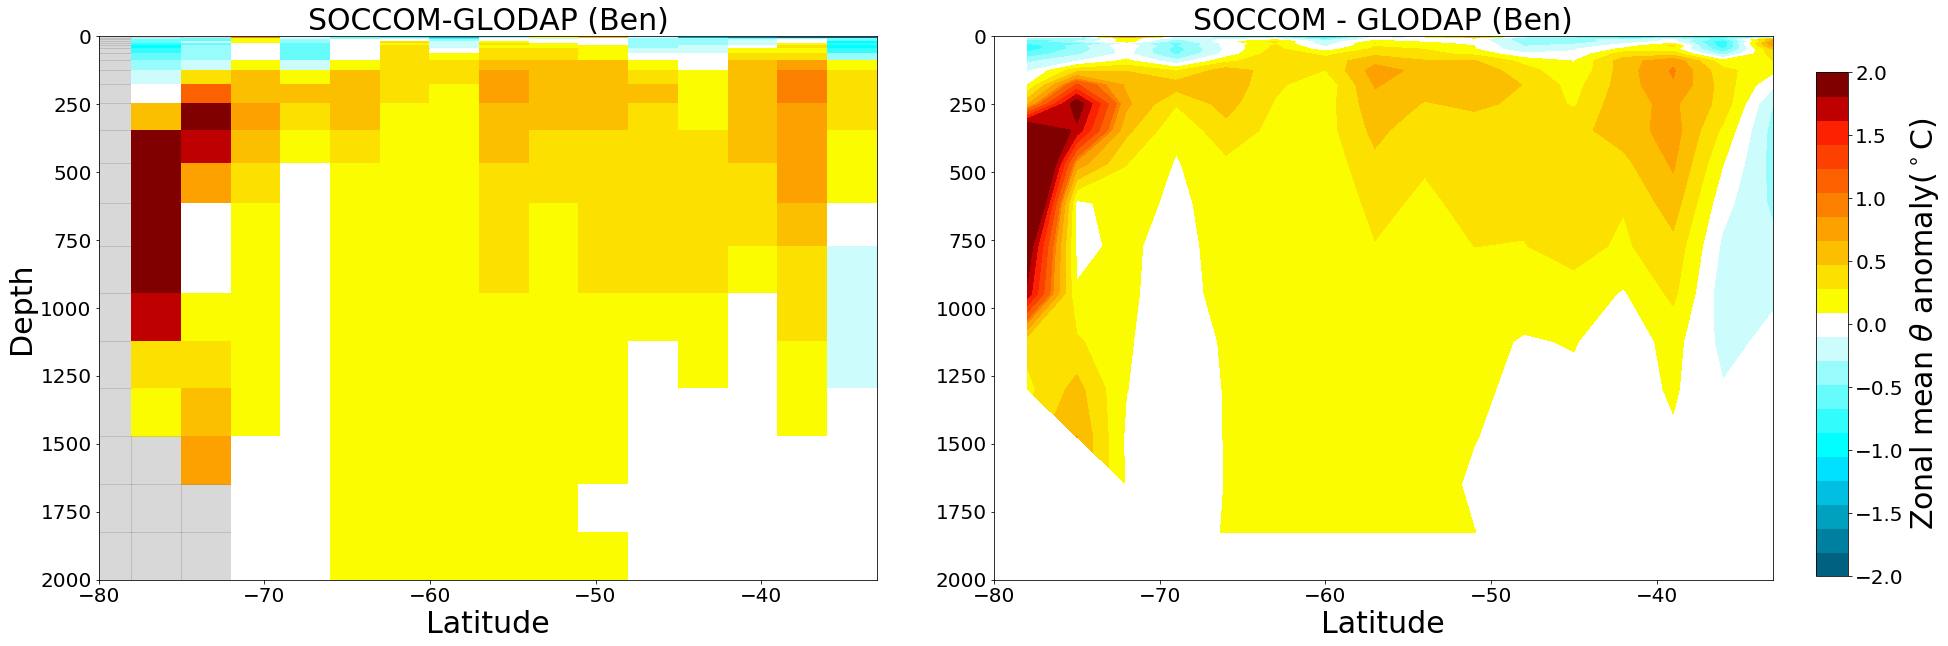

In [17]:
fig = plt.figure(figsize=[30, 10])
gs = gridspec.GridSpec(1,2)
ax, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])
gs.update(hspace = 0.2, wspace = 0.15)

cmap = nclcmaps.cmap('nrl_sirkes')
cmap.set_bad('grey',0.3)
norm = col.Normalize(vmin=-2,vmax=2) 
levels = np.arange(-2,2,0.1)
anomaly = ax.pcolormesh(Ben_anomaly_Temp_zonal.latitude-1.5,Ben_anomaly_Temp_zonal.depth, Ben_anomaly_Temp_zonal.values,cmap = cmap, norm =norm)
ax1.contourf(Ben_anomaly_Temp_zonal.latitude-1.5,Ben_anomaly_Temp_zonal.depth, Ben_anomaly_Temp_zonal.values,levels = levels,cmap = cmap, norm =norm, extend = 'both')

ax.set_ylim([2000,0])
ax.set_xlim([-80,-33])
ax1.set_ylim([2000,0])
ax1.set_xlim([-80,-33])
ax.set_ylabel('Depth', fontsize = 30)
ax.set_xlabel('Latitude', fontsize = 30)
ax1.set_xlabel('Latitude', fontsize = 30)
ax.set_title('SOCCOM-GLODAP (Ben)', fontsize = 30)
ax1.set_title('SOCCOM - GLODAP (Ben)', fontsize = 30)

cax = fig.add_axes([0.92, 0.13, 0.015, 0.7])
cbar=plt.colorbar(anomaly,cax = cax,orientation='vertical',shrink = 0.5)
cbar.set_label(r'Zonal mean $\theta$ anomaly($^\circ$C)', fontsize = 30)


figurepath = 'SOCCOM_GLODAP_BB-zonal.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

In [ ]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-2,vmax=2) 
levels = np.arange(-2,2.01,0.1)
temp = zonal_contour_plot(ax, Ben_anomaly_Temp_zonal, Ben_anomaly_Temp_zonal.latitude, Ben_anomaly_Temp_zonal.depth, cmap , norm , levels)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
#salt
norm = col.Normalize(vmin=-0.3,vmax=0.3) 
levels = np.arange(-0.3,0.31,0.02)
salt = zonal_contour_plot(ax1, Ben_anomaly_Salt_zonal, Ben_anomaly_Salt_zonal.latitude, Ben_anomaly_Salt_zonal.depth, cmap , norm , levels)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot(ax2, Ben_anomaly_Oxygen_zonal, Ben_anomaly_Oxygen_zonal.latitude, Ben_anomaly_Oxygen_zonal.depth, cmap , norm , levels)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot(ax3, Ben_anomaly_Nitrate_zonal, Ben_anomaly_Nitrate_zonal.latitude, Ben_anomaly_Nitrate_zonal.depth, cmap , norm , levels)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot(ax4, Ben_anomaly_DIC_zonal, Ben_anomaly_DIC_zonal.latitude, Ben_anomaly_DIC_zonal.depth, cmap , norm , levels)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#pH
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
pH = zonal_contour_plot(ax5, Ben_anomaly_pH_zonal, Ben_anomaly_pH_zonal.latitude, Ben_anomaly_pH_zonal.depth, cmap , norm , levels)
ax5.set_title(r'pH', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(pH,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

figurepath = 'F1_F2-original.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

## Reproduction, no bathymetry masking

#### no seasonal bias correction

(no pH but with density)

In [12]:
float_dir = '/work/Ruth.Moorman/SOCCOM-floats/LR_SOCCOM_20200308/'
ds = xr.open_dataset(float_dir+'ALL_FLOATS_TEMPERATURE-climatology-binned-bronselaer.nc')
soccom_temp_linear_grid = ds.linear.mean(dim = 'month')
soccom_temp_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_temp_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_temp_quad_grid = ds.quad.mean(dim = 'month')
soccom_temp_grid = (soccom_temp_linear_grid+ soccom_temp_nearest_grid+ soccom_temp_cubic_grid+ soccom_temp_quad_grid)/4
soccom_temp_profile_count = ds.profile_count

ds = xr.open_dataset(float_dir+'ALL_FLOATS_SALINITY-climatology-binned-bronselaer.nc')
soccom_salt_linear_grid = ds.linear.mean(dim = 'month')
soccom_salt_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_salt_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_salt_quad_grid = ds.quad.mean(dim = 'month')
soccom_salt_grid = (soccom_salt_linear_grid+ soccom_salt_nearest_grid+ soccom_salt_cubic_grid+ soccom_salt_quad_grid)/4
soccom_salt_profile_count = ds.profile_count

ds = xr.open_dataset(float_dir+'ALL_FLOATS_NITRATE-climatology-binned-bronselaer.nc')
soccom_nitrate_linear_grid = ds.linear.mean(dim = 'month')
soccom_nitrate_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_nitrate_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_nitrate_quad_grid = ds.quad.mean(dim = 'month')
soccom_nitrate_grid = (soccom_nitrate_linear_grid+ soccom_nitrate_nearest_grid+ soccom_nitrate_cubic_grid+ soccom_nitrate_quad_grid)/4
soccom_nitrate_profile_count = ds.profile_count

ds = xr.open_dataset(float_dir+'ALL_FLOATS_OXYGEN-climatology-binned-bronselaer.nc')
soccom_oxygen_linear_grid = ds.linear.mean(dim = 'month')
soccom_oxygen_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_oxygen_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_oxygen_quad_grid = ds.quad.mean(dim = 'month')
soccom_oxygen_grid = (soccom_oxygen_linear_grid+ soccom_oxygen_nearest_grid+ soccom_oxygen_cubic_grid+ soccom_oxygen_quad_grid)/4
soccom_oxygen_profile_count = ds.profile_count

ds = xr.open_dataset(float_dir+'ALL_FLOATS_DIC-climatology-binned-bronselaer.nc')
soccom_dic_linear_grid = ds.linear.mean(dim = 'month')
soccom_dic_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_dic_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_dic_quad_grid = ds.quad.mean(dim = 'month')
soccom_dic_grid = (soccom_dic_linear_grid+ soccom_dic_nearest_grid+ soccom_dic_cubic_grid+ soccom_dic_quad_grid)/4
soccom_dic_profile_count = ds.profile_count

float_dir = '/work/Ruth.Moorman/SOCCOM-floats/LR_SOCCOM_20200308/'
ds = xr.open_dataset(float_dir+'ALL_FLOATS_SIGMA-THETA-climatology-binned-bronselaer.nc')
soccom_sigma_linear_grid = ds.linear.mean(dim = 'month')
soccom_sigma_nearest_grid = ds.nearest.mean(dim = 'month')
soccom_sigma_cubic_grid = ds.cubic.mean(dim = 'month')
soccom_sigma_quad_grid = ds.quad.mean(dim = 'month')
soccom_sigma_grid = (soccom_sigma_linear_grid+ soccom_sigma_nearest_grid+ soccom_sigma_cubic_grid+ soccom_sigma_quad_grid)/4
soccom_sigma_profile_count = ds.profile_count

In [13]:
ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_TEMPERATURE-binned-bronselaer.nc')
glodap_temp_linear_grid = ds.linear
glodap_temp_nearest_grid = ds.nearest
glodap_temp_cubic_grid = ds.cubic
glodap_temp_quad_grid = ds.quad
glodap_temp_grid = (glodap_temp_linear_grid+glodap_temp_nearest_grid+glodap_temp_cubic_grid+glodap_temp_quad_grid)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_SALINITY-binned-bronselaer.nc')
glodap_salt_linear_grid = ds.linear
glodap_salt_nearest_grid = ds.nearest
glodap_salt_cubic_grid = ds.cubic
glodap_salt_quad_grid = ds.quad
glodap_salt_grid = (glodap_salt_linear_grid+glodap_salt_nearest_grid+glodap_salt_cubic_grid+glodap_salt_quad_grid)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_OXYGEN-binned-bronselaer.nc')
glodap_oxyg_linear_grid = ds.linear
glodap_oxyg_nearest_grid = ds.nearest
glodap_oxyg_cubic_grid = ds.cubic
glodap_oxyg_quad_grid = ds.quad
glodap_oxyg_grid = (glodap_oxyg_linear_grid+glodap_oxyg_nearest_grid+glodap_oxyg_cubic_grid+glodap_oxyg_quad_grid)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_NITRATE-binned-bronselaer.nc')
glodap_nitr_linear_grid = ds.linear
glodap_nitr_nearest_grid = ds.nearest
glodap_nitr_cubic_grid = ds.cubic
glodap_nitr_quad_grid = ds.quad
glodap_nitr_grid = (glodap_nitr_linear_grid+glodap_nitr_nearest_grid+glodap_nitr_cubic_grid+glodap_nitr_quad_grid)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_DIC-binned-bronselaer.nc')
glodap_dic_linear_grid = ds.linear
glodap_dic_nearest_grid = ds.nearest
glodap_dic_cubic_grid = ds.cubic
glodap_dic_quad_grid = ds.quad
glodap_dic_grid = (glodap_dic_linear_grid+glodap_dic_nearest_grid+glodap_dic_cubic_grid+glodap_dic_quad_grid)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_SIGMA-binned-bronselaer.nc')
glodap_sigma_linear_grid = ds.linear
glodap_sigma_nearest_grid = ds.nearest
glodap_sigma_cubic_grid = ds.cubic
glodap_sigma_quad_grid = ds.quad
glodap_sigma_grid = (glodap_sigma_linear_grid+glodap_sigma_nearest_grid+glodap_sigma_cubic_grid+glodap_sigma_quad_grid)/4

In [14]:
Ruth_anomaly_Temp_zonal, Ruth_SOCCOM_Temp_zonal, Ruth_GLODAP_Temp_zonal = zonal_mean_overlapping(soccom_temp_grid,glodap_temp_grid)
Ruth_anomaly_Salt_zonal, Ruth_SOCCOM_Salt_zonal, Ruth_GLODAP_Salt_zonal = zonal_mean_overlapping(soccom_salt_grid,glodap_salt_grid)
Ruth_anomaly_Oxygen_zonal, Ruth_SOCCOM_Oxygen_zonal, Ruth_GLODAP_Oxygen_zonal = zonal_mean_overlapping(soccom_oxygen_grid,glodap_oxyg_grid)
Ruth_anomaly_Nitrate_zonal, Ruth_SOCCOM_Nitrate_zonal, Ruth_GLODAP_Nitrate_zonal = zonal_mean_overlapping(soccom_nitrate_grid,glodap_nitr_grid)
Ruth_anomaly_DIC_zonal, Ruth_SOCCOM_DIC_zonal, Ruth_GLODAP_DIC_zonal = zonal_mean_overlapping(soccom_dic_grid,glodap_dic_grid)
Ruth_anomaly_Sigma_zonal, Ruth_SOCCOM_Sigma_zonal, Ruth_GLODAP_Sigma_zonal = zonal_mean_overlapping(soccom_sigma_grid,glodap_sigma_grid)

In [15]:
def zonal_contour_plot_sigma(ax, zonal_anomaly, latitude, depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal):
    colorbar = ax.contourf(latitude,depth, zonal_anomaly.values.T,levels = levels,cmap = cmap, norm = norm, extend = 'both')
    bathy_zonal = zonal_anomaly*0
    bathy_zonal = bathy_zonal.fillna(1)
    ax.contour(bathy_zonal.latitude,bathy_zonal.depth,bathy_zonal.values.T,[-1],colors = 'k', alpha = 0.1)
    sigma_levels = np.arange(25,29,0.25)
    mask = zonal_anomaly * 0 + 1
    soccom_sigma = soccom_sigma*mask
    glodap_sigma = glodap_sigma*mask
    ax.contour(soccom_sigma.latitude, soccom_sigma.depth, soccom_sigma.values.T, levels=sigma_levels, colors = 'k', linestyles = 'dashed',linewidths=1, alpha = 1)
    ax.contour(glodap_sigma.latitude, glodap_sigma.depth, glodap_sigma.values.T, levels=sigma_levels, colors = 'k', linewidths=1, alpha = 1)
    ax.set_ylim([2000,0])
    ax.set_xlim([-80,-33])
    return colorbar

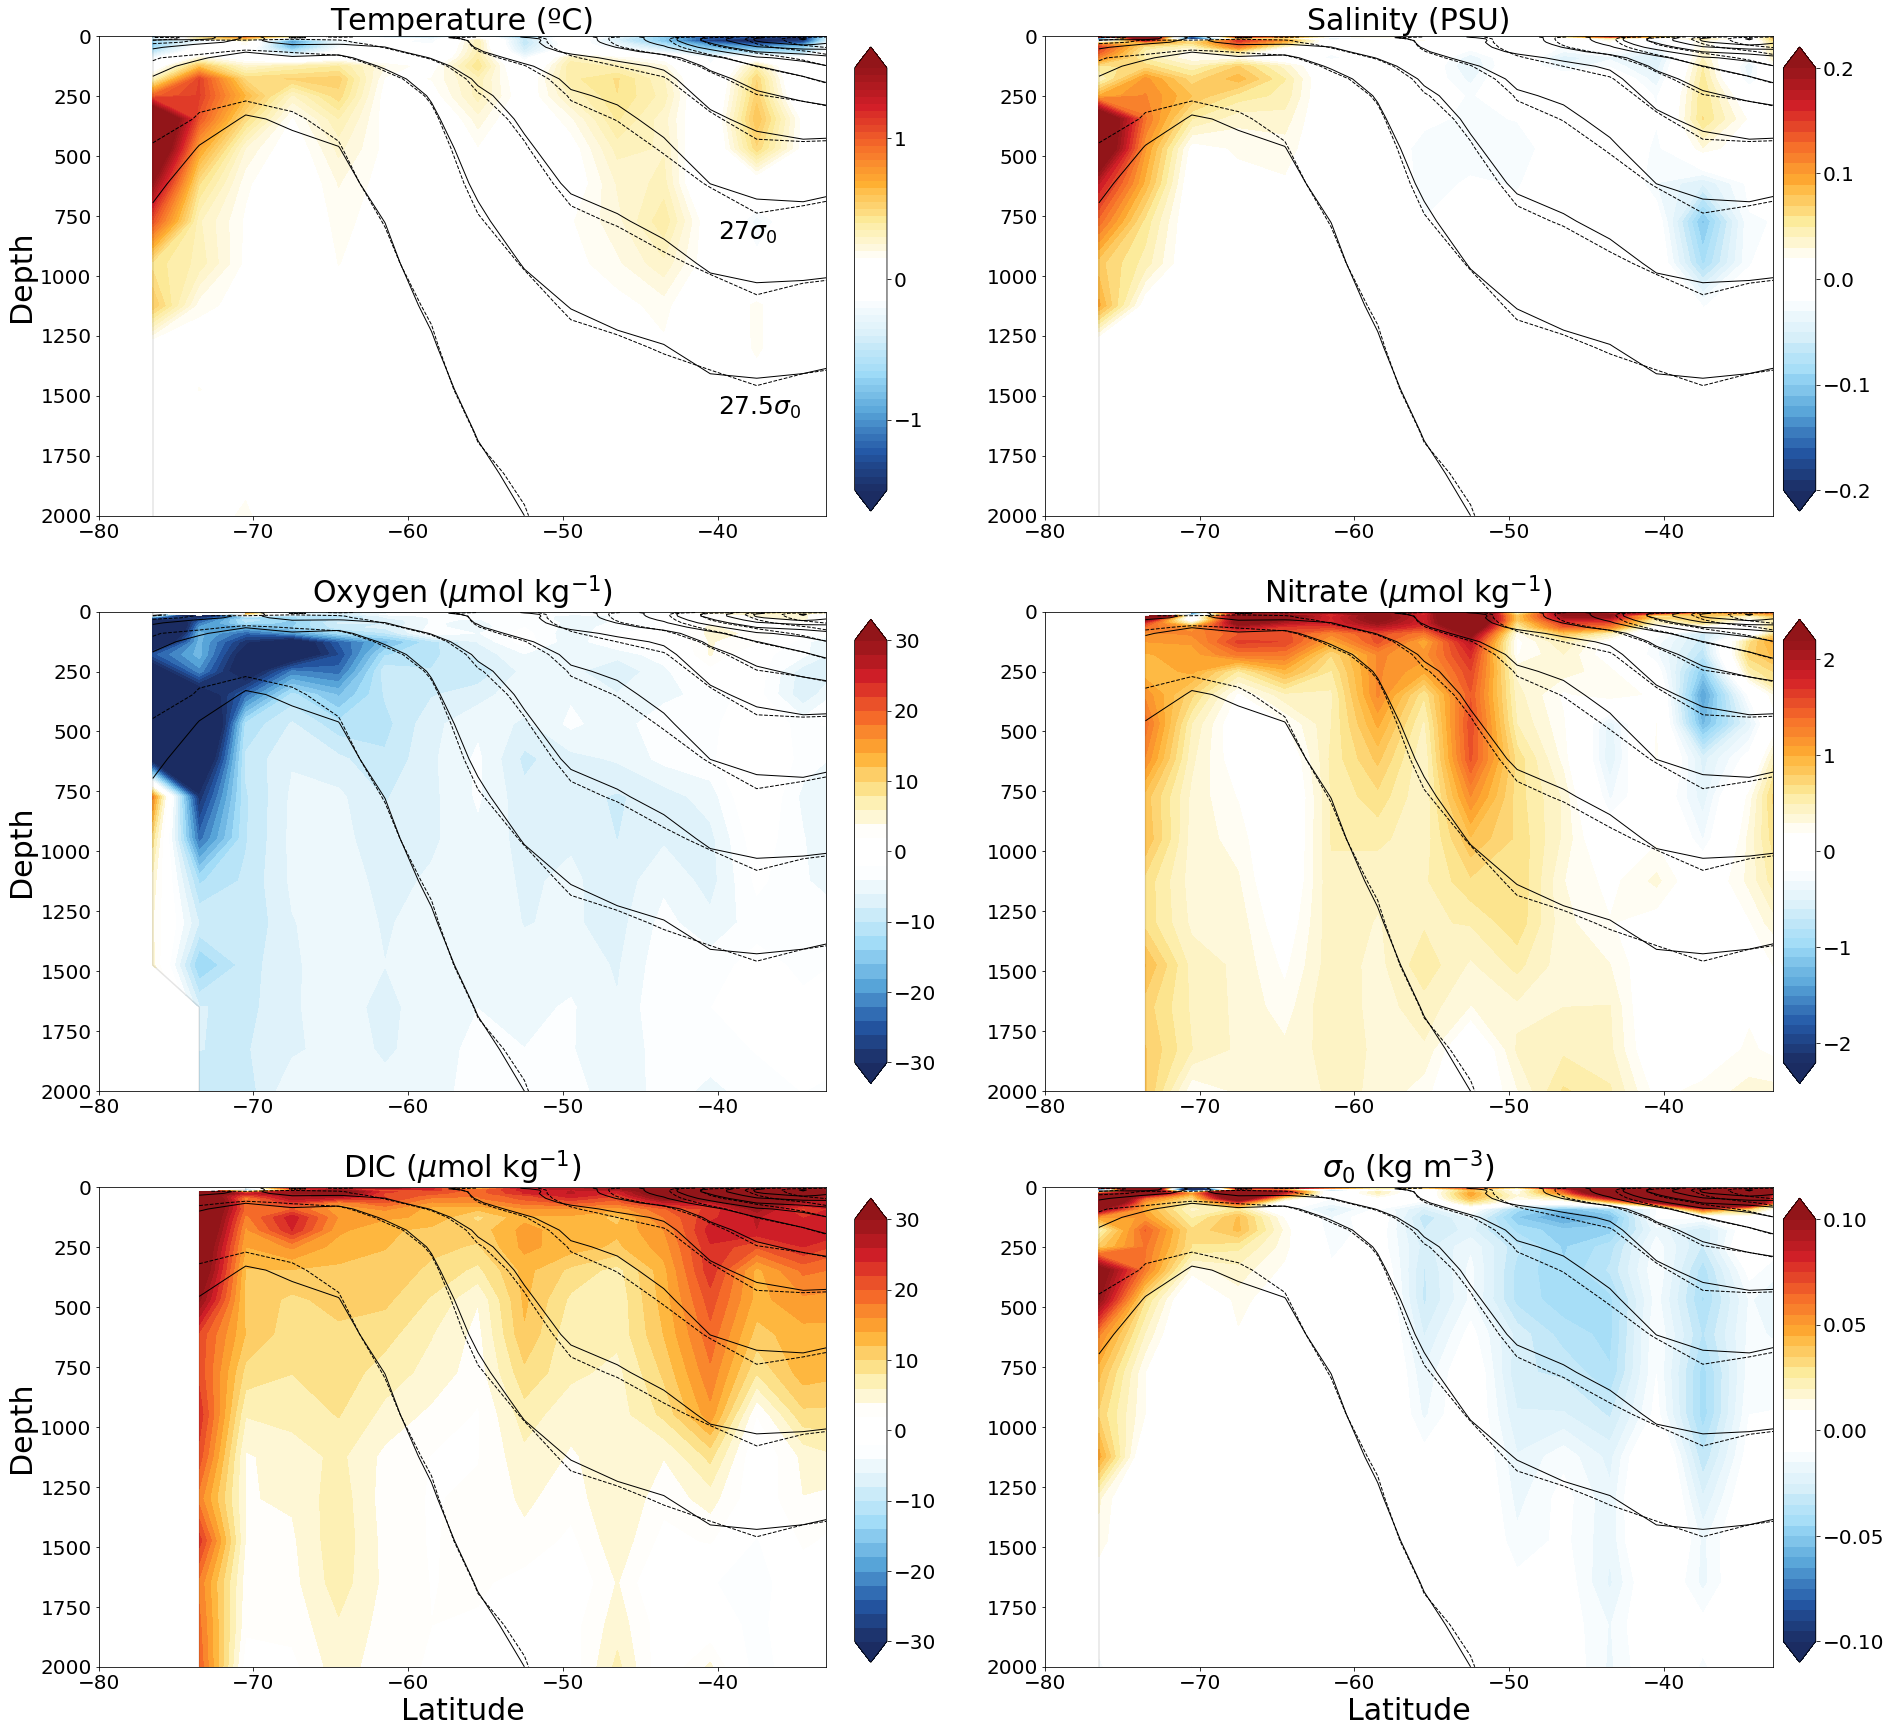

In [16]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_anomaly_Temp_zonal, Ruth_anomaly_Temp_zonal.latitude, Ruth_anomaly_Temp_zonal.depth, cmap , norm , levels)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_anomaly_Salt_zonal, Ruth_anomaly_Salt_zonal.latitude, Ruth_anomaly_Salt_zonal.depth, cmap , norm , levels)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_anomaly_Oxygen_zonal, Ruth_anomaly_Oxygen_zonal.latitude, Ruth_anomaly_Oxygen_zonal.depth, cmap , norm , levels)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_anomaly_Nitrate_zonal, Ruth_anomaly_Nitrate_zonal.latitude, Ruth_anomaly_Nitrate_zonal.depth, cmap , norm , levels)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_anomaly_DIC_zonal, Ruth_anomaly_DIC_zonal.latitude, Ruth_anomaly_DIC_zonal.depth, cmap , norm , levels)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_anomaly_Sigma_zonal, Ruth_anomaly_Sigma_zonal.latitude, Ruth_anomaly_Sigma_zonal.depth, cmap , norm , levels)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

# figurepath = 'F1_F2-original.png'
# plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

##### add a seasonal bias correction

In [17]:
float_dir = '/work/Ruth.Moorman/SOCCOM-floats/LR_SOCCOM_20200308/'
ds = xr.open_dataset(float_dir+'ALL_FLOATS_TEMPERATURE-climatology-binned-bronselaer.nc')
soccom_temp_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_temp_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_temp_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_temp_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_temp_grid_DJFMAM = (soccom_temp_linear_grid_DJFMAM+ soccom_temp_nearest_grid_DJFMAM+ soccom_temp_cubic_grid_DJFMAM+ soccom_temp_quad_grid_DJFMAM)/4

ds = xr.open_dataset(float_dir+'ALL_FLOATS_SALINITY-climatology-binned-bronselaer.nc')
soccom_salt_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_salt_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_salt_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_salt_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_salt_grid_DJFMAM = (soccom_salt_linear_grid_DJFMAM+ soccom_salt_nearest_grid_DJFMAM+ soccom_salt_cubic_grid_DJFMAM+ soccom_salt_quad_grid_DJFMAM)/4

ds = xr.open_dataset(float_dir+'ALL_FLOATS_NITRATE-climatology-binned-bronselaer.nc')
soccom_nitrate_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_nitrate_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_nitrate_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_nitrate_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_nitrate_grid_DJFMAM = (soccom_nitrate_linear_grid_DJFMAM+ soccom_nitrate_nearest_grid_DJFMAM+ soccom_nitrate_cubic_grid_DJFMAM+ soccom_nitrate_quad_grid_DJFMAM)/4

ds = xr.open_dataset(float_dir+'ALL_FLOATS_OXYGEN-climatology-binned-bronselaer.nc')
soccom_oxygen_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_oxygen_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_oxygen_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_oxygen_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_oxygen_grid_DJFMAM = (soccom_oxygen_linear_grid_DJFMAM+ soccom_oxygen_nearest_grid_DJFMAM+ soccom_oxygen_cubic_grid_DJFMAM+ soccom_oxygen_quad_grid_DJFMAM)/4

ds = xr.open_dataset(float_dir+'ALL_FLOATS_DIC-climatology-binned-bronselaer.nc')
soccom_dic_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_dic_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_dic_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_dic_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_dic_grid_DJFMAM = (soccom_dic_linear_grid_DJFMAM+ soccom_dic_nearest_grid_DJFMAM+ soccom_dic_cubic_grid_DJFMAM+ soccom_dic_quad_grid_DJFMAM)/4

float_dir = '/work/Ruth.Moorman/SOCCOM-floats/LR_SOCCOM_20200308/'
ds = xr.open_dataset(float_dir+'ALL_FLOATS_SIGMA-THETA-climatology-binned-bronselaer.nc')
soccom_sigma_linear_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).linear.mean(dim = 'month')
soccom_sigma_nearest_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).nearest.mean(dim = 'month')
soccom_sigma_cubic_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).cubic.mean(dim = 'month')
soccom_sigma_quad_grid_DJFMAM = ds.sel(month = [12,1,2,3,4,5]).quad.mean(dim = 'month')
soccom_sigma_grid_DJFMAM = (soccom_sigma_linear_grid_DJFMAM+ soccom_sigma_nearest_grid_DJFMAM+ soccom_sigma_cubic_grid_DJFMAM+ soccom_sigma_quad_grid_DJFMAM)/4

In [18]:
_ , Ruth_SOCCOM_Temp_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_temp_grid_DJFMAM,glodap_temp_grid)
_ , Ruth_SOCCOM_Salt_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_salt_grid_DJFMAM,glodap_salt_grid)
_ , Ruth_SOCCOM_Oxygen_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_oxygen_grid_DJFMAM,glodap_oxyg_grid)
_ , Ruth_SOCCOM_Nitrate_zonal_DJFMAM,_  = zonal_mean_overlapping(soccom_nitrate_grid_DJFMAM,glodap_nitr_grid)
_ , Ruth_SOCCOM_DIC_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_dic_grid_DJFMAM,glodap_dic_grid)
_ , Ruth_SOCCOM_Sigma_zonal_DJFMAM,  _= zonal_mean_overlapping(soccom_sigma_grid_DJFMAM,glodap_sigma_grid)

In [19]:
Ruth_SOCCOM_Temp_zonal_summer_bias = Ruth_SOCCOM_Temp_zonal_DJFMAM - Ruth_SOCCOM_Temp_zonal
Ruth_SOCCOM_Salt_zonal_summer_bias  = Ruth_SOCCOM_Salt_zonal_DJFMAM - Ruth_SOCCOM_Salt_zonal
Ruth_SOCCOM_Oxygen_zonal_summer_bias  = Ruth_SOCCOM_Oxygen_zonal_DJFMAM - Ruth_SOCCOM_Oxygen_zonal
Ruth_SOCCOM_Nitrate_zonal_summer_bias  = Ruth_SOCCOM_Nitrate_zonal_DJFMAM - Ruth_SOCCOM_Nitrate_zonal
Ruth_SOCCOM_DIC_zonal_summer_bias  = Ruth_SOCCOM_DIC_zonal_DJFMAM - Ruth_SOCCOM_DIC_zonal
Ruth_SOCCOM_Sigma_zonal_summer_bias  = Ruth_SOCCOM_Sigma_zonal_DJFMAM - Ruth_SOCCOM_Sigma_zonal

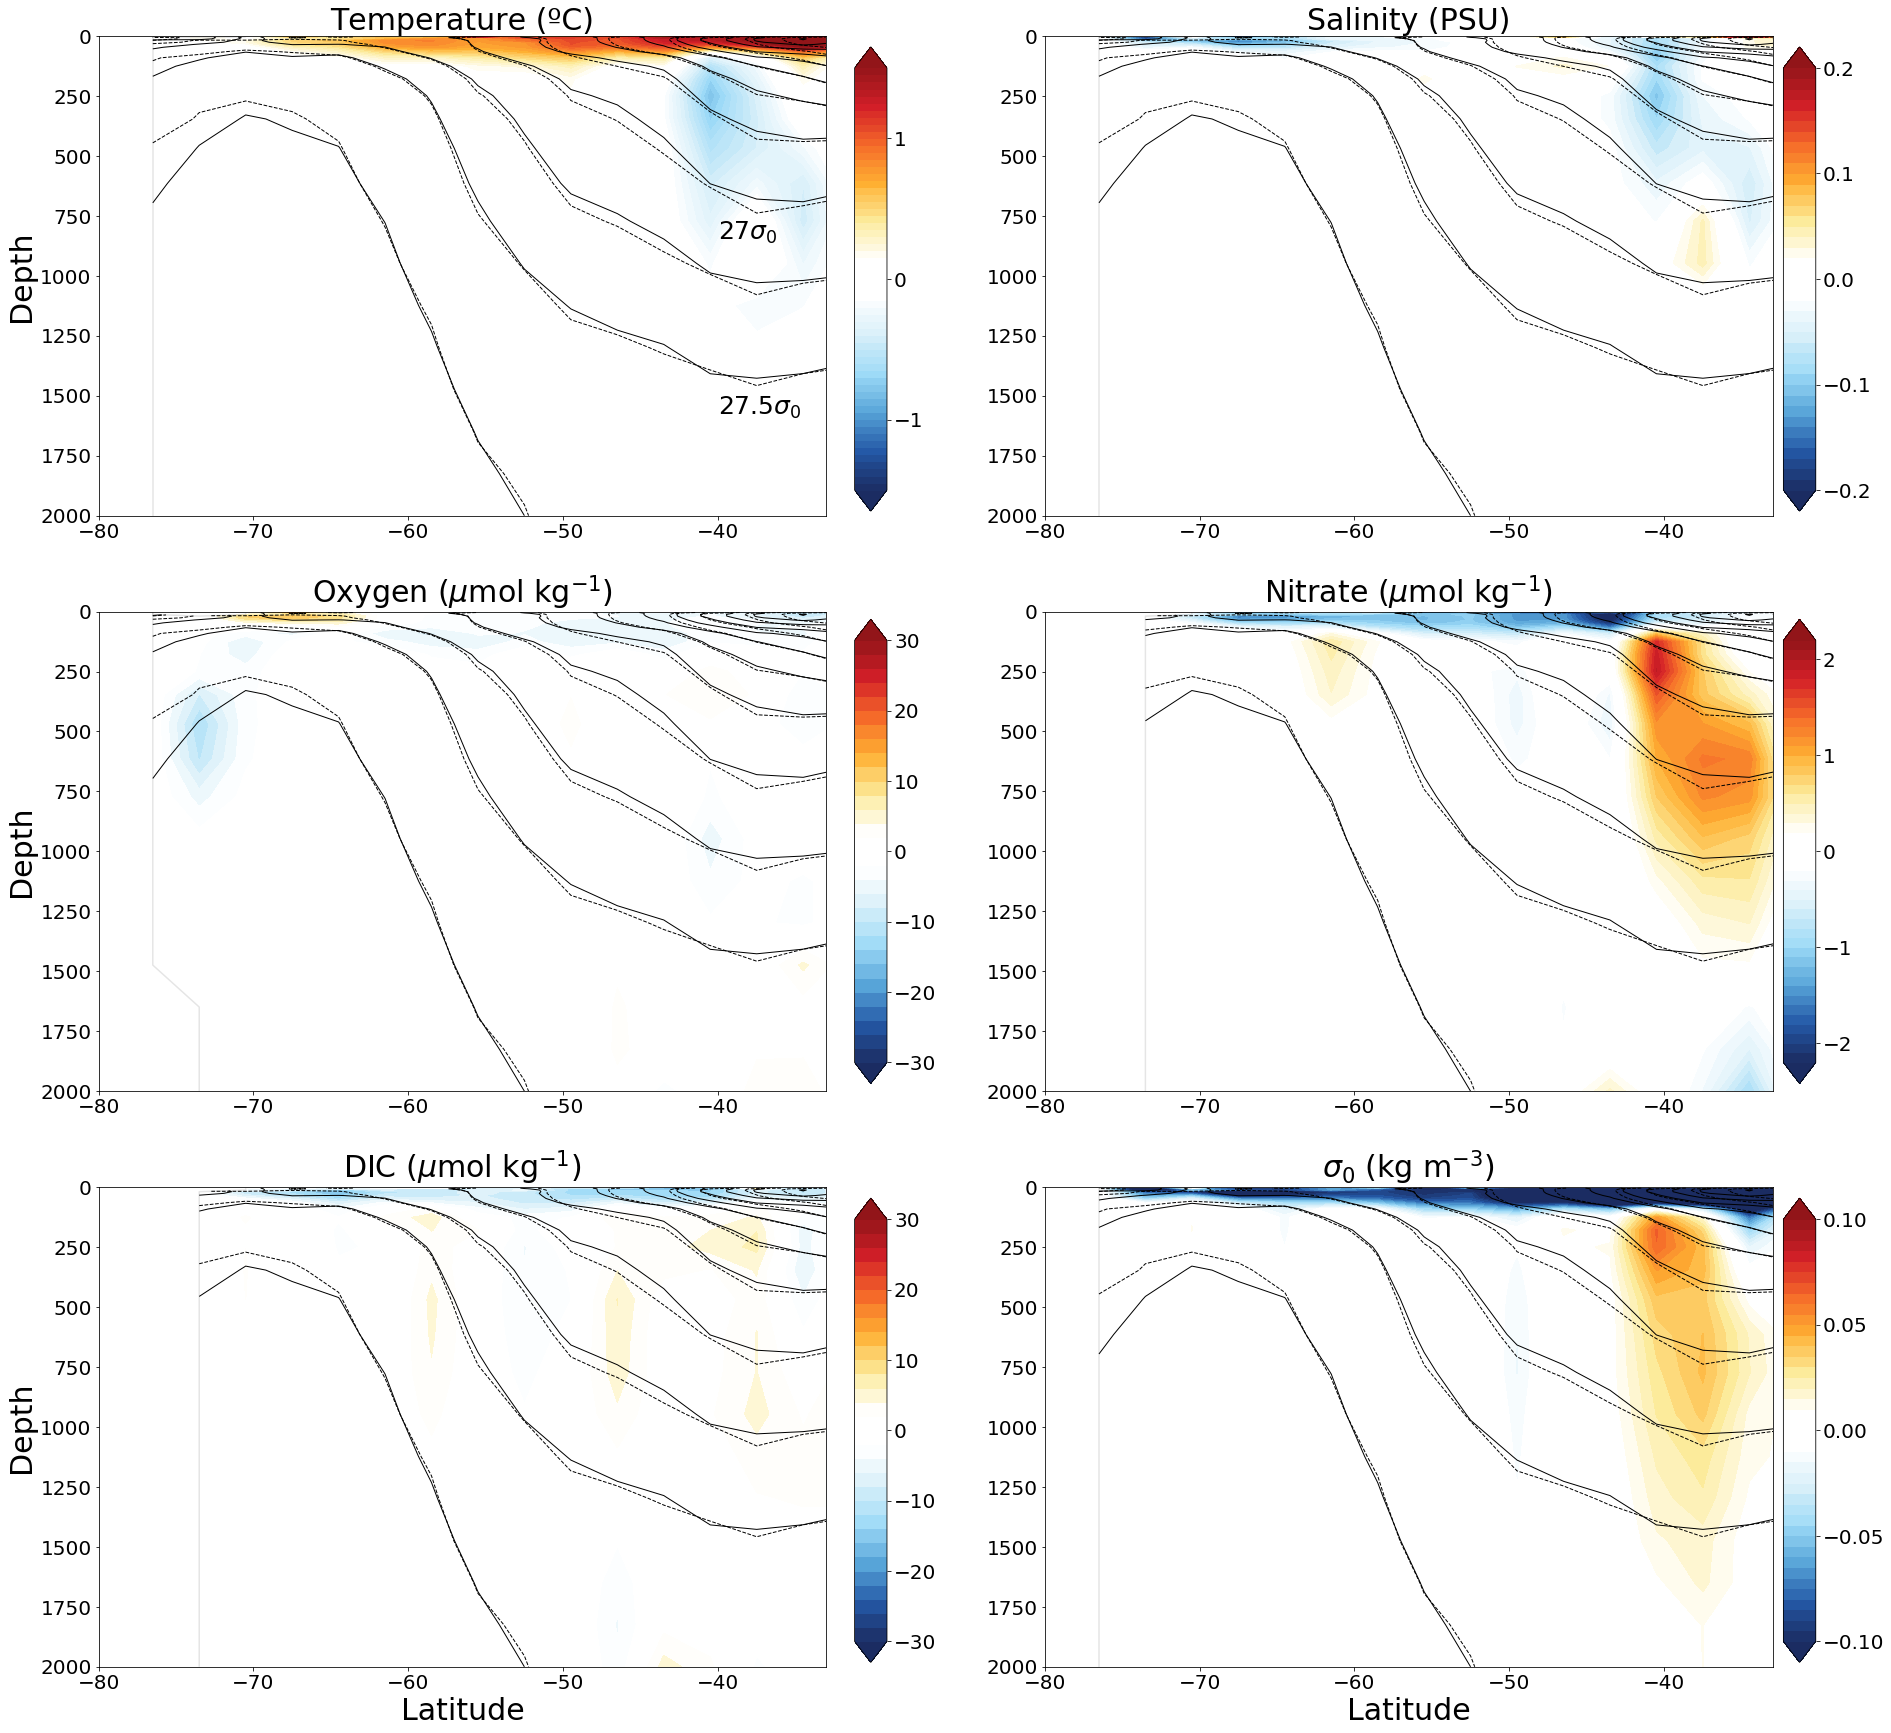

In [20]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_SOCCOM_Temp_zonal_summer_bias, Ruth_SOCCOM_Temp_zonal_summer_bias.latitude, Ruth_SOCCOM_Temp_zonal_summer_bias.depth, cmap , norm , levels)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_SOCCOM_Salt_zonal_summer_bias, Ruth_SOCCOM_Salt_zonal_summer_bias.latitude, Ruth_SOCCOM_Salt_zonal_summer_bias.depth, cmap , norm , levels)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_SOCCOM_Oxygen_zonal_summer_bias, Ruth_SOCCOM_Oxygen_zonal_summer_bias.latitude, Ruth_SOCCOM_Oxygen_zonal_summer_bias.depth, cmap , norm , levels)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_SOCCOM_Nitrate_zonal_summer_bias, Ruth_SOCCOM_Nitrate_zonal_summer_bias.latitude, Ruth_SOCCOM_Nitrate_zonal_summer_bias.depth, cmap , norm , levels)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_SOCCOM_DIC_zonal_summer_bias, Ruth_SOCCOM_DIC_zonal_summer_bias.latitude, Ruth_SOCCOM_DIC_zonal_summer_bias.depth, cmap , norm , levels)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_SOCCOM_Sigma_zonal_summer_bias, Ruth_SOCCOM_Sigma_zonal_summer_bias.latitude, Ruth_SOCCOM_Sigma_zonal_summer_bias.depth, cmap , norm , levels)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

# figurepath = 'F1_F2-reproduction-no-bathymery.png'
# plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

In [21]:
# glodap seasonal bias correction
Ruth_GLODAP_Temp_zonal_BC = Ruth_GLODAP_Temp_zonal - Ruth_SOCCOM_Temp_zonal_summer_bias
Ruth_GLODAP_Salt_zonal_BC = Ruth_GLODAP_Salt_zonal - Ruth_SOCCOM_Salt_zonal_summer_bias
Ruth_GLODAP_Oxygen_zonal_BC = Ruth_GLODAP_Oxygen_zonal - Ruth_SOCCOM_Oxygen_zonal_summer_bias
Ruth_GLODAP_Nitrate_zonal_BC = Ruth_GLODAP_Nitrate_zonal - Ruth_SOCCOM_Nitrate_zonal_summer_bias
Ruth_GLODAP_DIC_zonal_BC = Ruth_GLODAP_DIC_zonal - Ruth_SOCCOM_DIC_zonal_summer_bias
Ruth_GLODAP_Sigma_zonal_BC = Ruth_GLODAP_Sigma_zonal - Ruth_SOCCOM_Sigma_zonal_summer_bias

In [22]:
Ruth_anomaly_Temp_zonal_BC = Ruth_SOCCOM_Temp_zonal - Ruth_GLODAP_Temp_zonal_BC
Ruth_anomaly_Salt_zonal_BC = Ruth_SOCCOM_Salt_zonal - Ruth_GLODAP_Salt_zonal_BC
Ruth_anomaly_Oxygen_zonal_BC = Ruth_SOCCOM_Oxygen_zonal - Ruth_GLODAP_Oxygen_zonal_BC
Ruth_anomaly_Nitrate_zonal_BC = Ruth_SOCCOM_Nitrate_zonal - Ruth_GLODAP_Nitrate_zonal_BC
Ruth_anomaly_DIC_zonal_BC = Ruth_SOCCOM_DIC_zonal - Ruth_GLODAP_DIC_zonal_BC
Ruth_anomaly_Sigma_zonal_BC = Ruth_SOCCOM_Sigma_zonal - Ruth_GLODAP_Sigma_zonal_BC

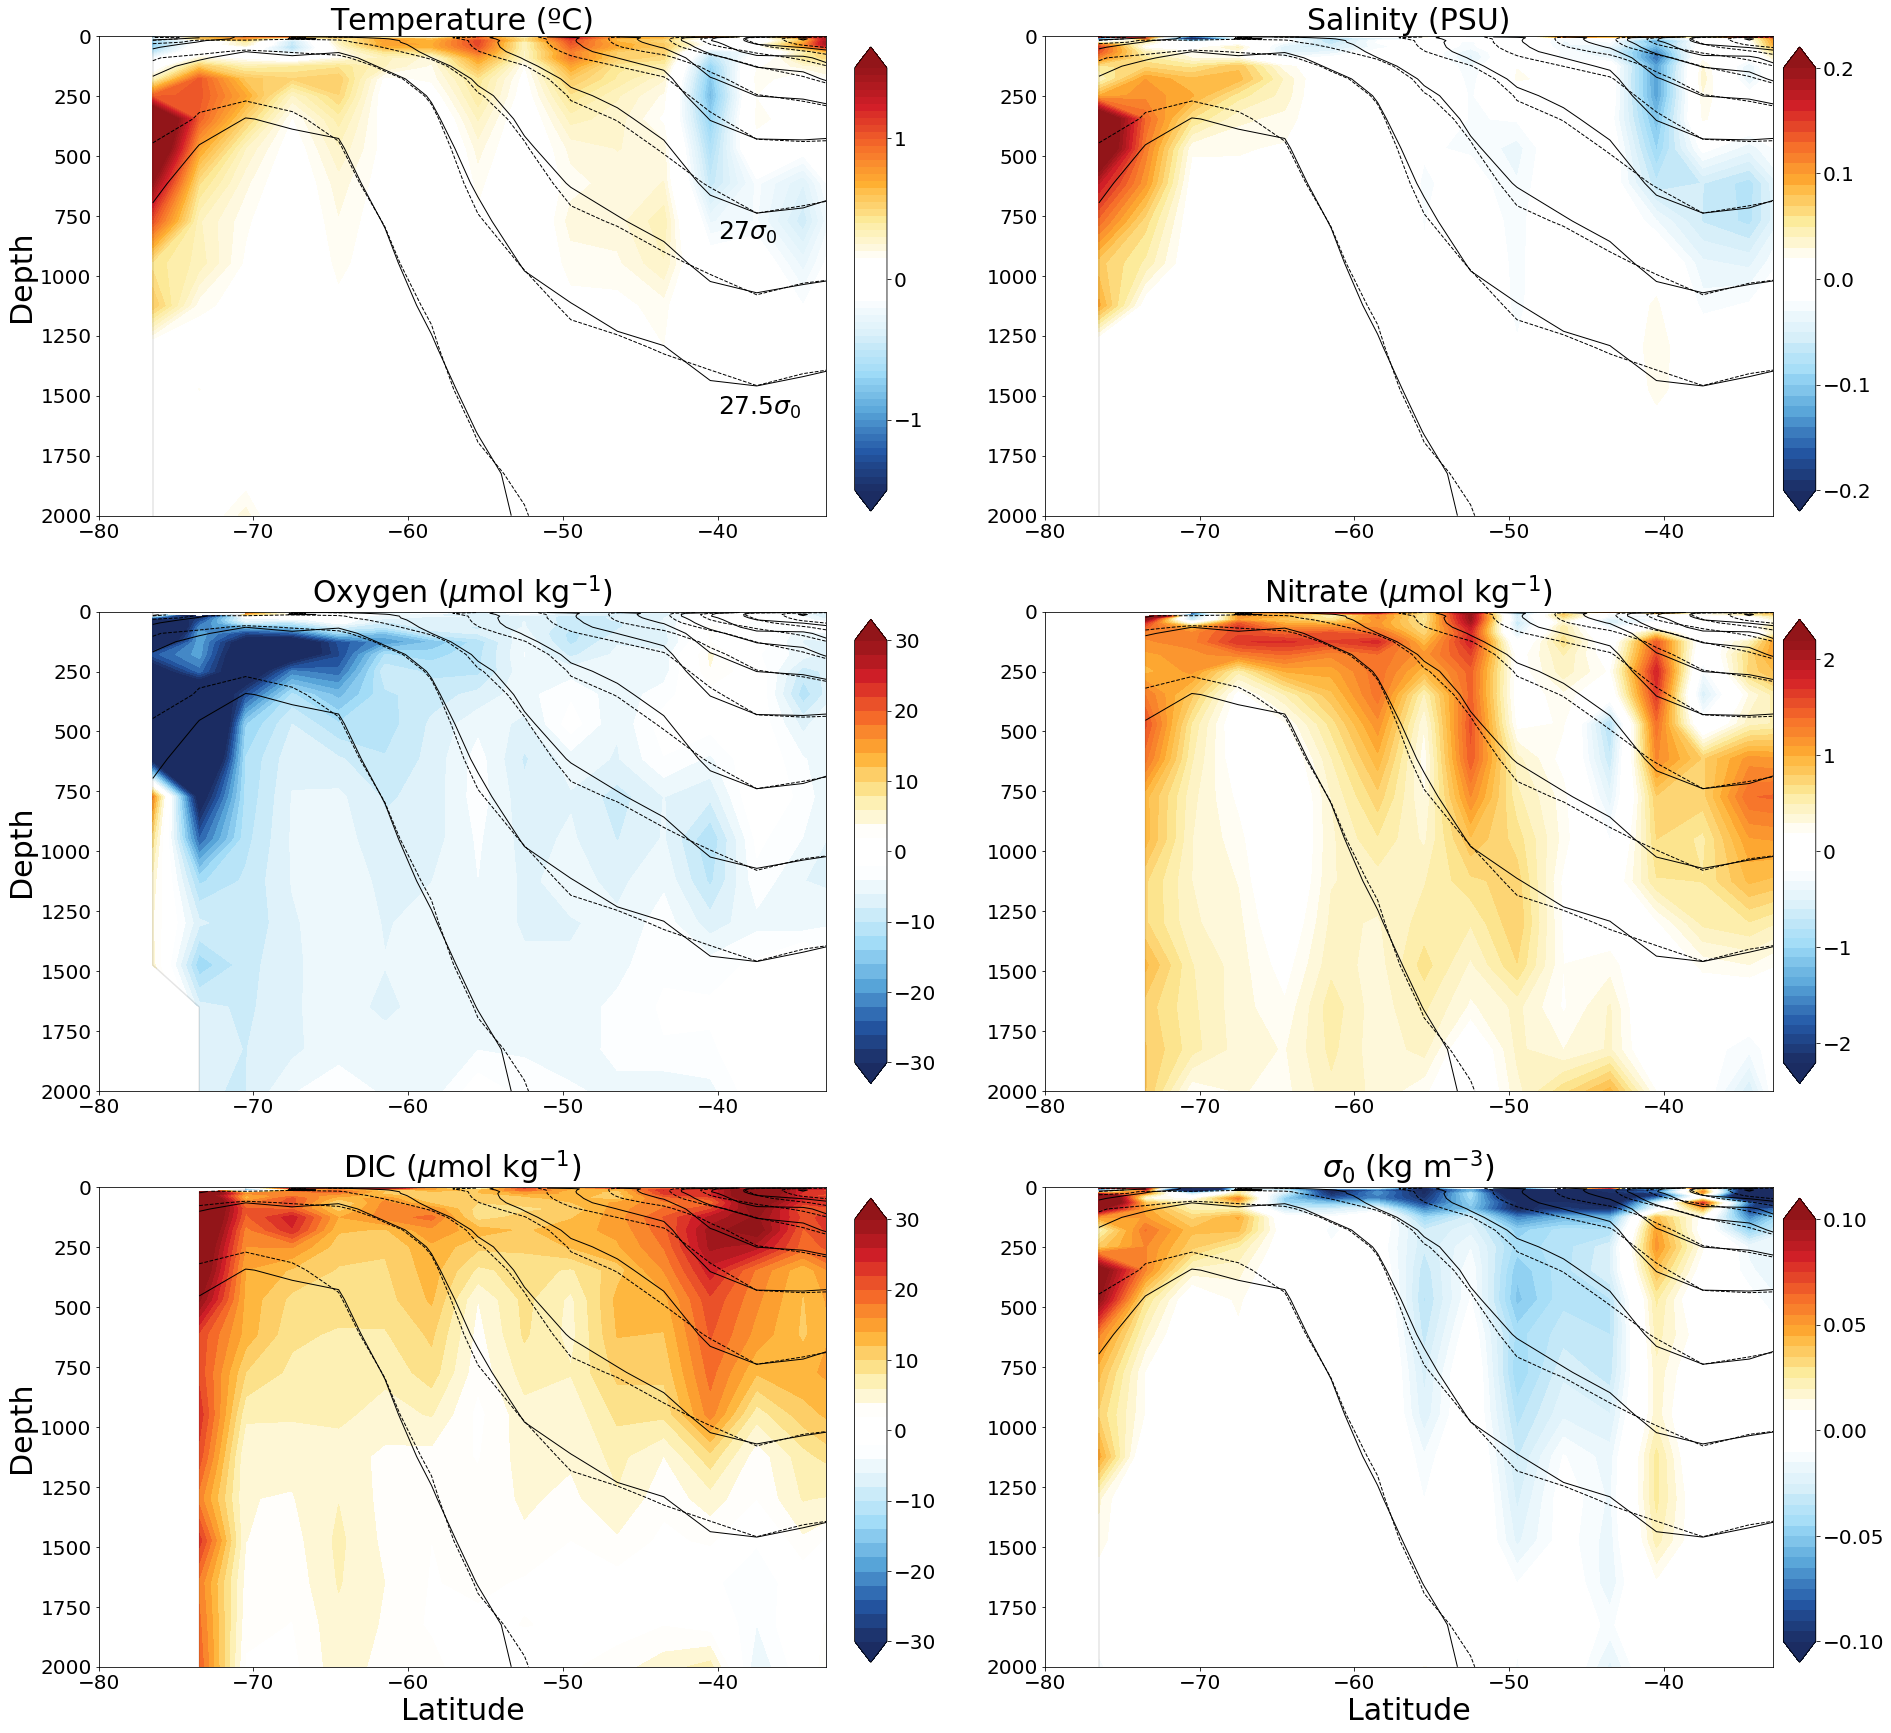

In [23]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_anomaly_Temp_zonal_BC, Ruth_anomaly_Temp_zonal_BC.latitude, Ruth_anomaly_Temp_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_anomaly_Salt_zonal_BC, Ruth_anomaly_Salt_zonal_BC.latitude, Ruth_anomaly_Salt_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_anomaly_Oxygen_zonal_BC, Ruth_anomaly_Oxygen_zonal_BC.latitude, Ruth_anomaly_Oxygen_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_anomaly_Nitrate_zonal_BC, Ruth_anomaly_Nitrate_zonal_BC.latitude, Ruth_anomaly_Nitrate_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_anomaly_DIC_zonal_BC, Ruth_anomaly_DIC_zonal_BC.latitude, Ruth_anomaly_DIC_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_anomaly_Sigma_zonal_BC, Ruth_anomaly_Sigma_zonal_BC.latitude, Ruth_anomaly_Sigma_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

figurepath = 'F1_F2-reproduction-no-bathymetry.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

## Reproduction: with bathymetry masking

##### no seasonal masking

In [24]:
ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_TEMPERATURE-binned-bathymetry-masked.nc')
glodap_temp_linear_grid_bathy = ds.linear
glodap_temp_nearest_grid_bathy = ds.nearest
glodap_temp_cubic_grid_bathy = ds.cubic
glodap_temp_quad_grid_bathy = ds.quad
glodap_temp_grid_bathy = (glodap_temp_linear_grid_bathy+glodap_temp_nearest_grid_bathy+glodap_temp_cubic_grid_bathy+glodap_temp_quad_grid_bathy)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_SALINITY-binned-bathymetry-masked.nc')
glodap_salt_linear_grid_bathy = ds.linear
glodap_salt_nearest_grid_bathy = ds.nearest
glodap_salt_cubic_grid_bathy = ds.cubic
glodap_salt_quad_grid_bathy = ds.quad
glodap_salt_grid_bathy = (glodap_salt_linear_grid_bathy+glodap_salt_nearest_grid_bathy+glodap_salt_cubic_grid_bathy+glodap_salt_quad_grid_bathy)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_OXYGEN-binned-bathymetry-masked.nc')
glodap_oxyg_linear_grid_bathy = ds.linear
glodap_oxyg_nearest_grid_bathy = ds.nearest
glodap_oxyg_cubic_grid_bathy = ds.cubic
glodap_oxyg_quad_grid_bathy = ds.quad
glodap_oxyg_grid_bathy = (glodap_oxyg_linear_grid_bathy+glodap_oxyg_nearest_grid_bathy+glodap_oxyg_cubic_grid_bathy+glodap_oxyg_quad_grid_bathy)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_NITRATE-binned-bronselaer.nc')
glodap_nitr_linear_grid_bathy = ds.linear
glodap_nitr_nearest_grid_bathy = ds.nearest
glodap_nitr_cubic_grid_bathy = ds.cubic
glodap_nitr_quad_grid_bathy = ds.quad
glodap_nitr_grid_bathy = (glodap_nitr_linear_grid_bathy+glodap_nitr_nearest_grid_bathy+glodap_nitr_cubic_grid_bathy+glodap_nitr_quad_grid_bathy)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_DIC-binned-bathymetry-masked.nc')
glodap_dic_linear_grid_bathy = ds.linear
glodap_dic_nearest_grid_bathy = ds.nearest
glodap_dic_cubic_grid_bathy = ds.cubic
glodap_dic_quad_grid_bathy = ds.quad
glodap_dic_grid_bathy = (glodap_dic_linear_grid_bathy+glodap_dic_nearest_grid_bathy+glodap_dic_cubic_grid_bathy+glodap_dic_quad_grid_bathy)/4

ds = xr.open_dataset('/work/Ruth.Moorman/GLODAP/ALL_PROFILES_SIGMA-binned-bathymetry-masked.nc')
glodap_sigma_linear_grid_bathy = ds.linear
glodap_sigma_nearest_grid_bathy = ds.nearest
glodap_sigma_cubic_grid_bathy = ds.cubic
glodap_sigma_quad_grid_bathy = ds.quad
glodap_sigma_grid_bathy = (glodap_sigma_linear_grid_bathy+glodap_sigma_nearest_grid_bathy+glodap_sigma_cubic_grid_bathy+glodap_sigma_quad_grid_bathy)/4

In [25]:
Ruth_anomaly_Temp_zonal_bathy, Ruth_SOCCOM_Temp_zonal_bathy, Ruth_GLODAP_Temp_zonal_bathy = zonal_mean_overlapping(soccom_temp_grid,glodap_temp_grid_bathy)
Ruth_anomaly_Salt_zonal_bathy, Ruth_SOCCOM_Salt_zonal_bathy, Ruth_GLODAP_Salt_zonal_bathy = zonal_mean_overlapping(soccom_salt_grid,glodap_salt_grid_bathy)
Ruth_anomaly_Oxygen_zonal_bathy, Ruth_SOCCOM_Oxygen_zonal_bathy, Ruth_GLODAP_Oxygen_zonal_bathy = zonal_mean_overlapping(soccom_oxygen_grid,glodap_oxyg_grid_bathy)
Ruth_anomaly_Nitrate_zonal_bathy, Ruth_SOCCOM_Nitrate_zonal_bathy, Ruth_GLODAP_Nitrate_zonal_bathy = zonal_mean_overlapping(soccom_nitrate_grid,glodap_nitr_grid_bathy)
Ruth_anomaly_DIC_zonal_bathy, Ruth_SOCCOM_DIC_zonal_bathy, Ruth_GLODAP_DIC_zonal_bathy = zonal_mean_overlapping(soccom_dic_grid,glodap_dic_grid_bathy)
Ruth_anomaly_Sigma_zonal_bathy, Ruth_SOCCOM_Sigma_zonal_bathy, Ruth_GLODAP_Sigma_zonal_bathy = zonal_mean_overlapping(soccom_sigma_grid,glodap_sigma_grid_bathy)

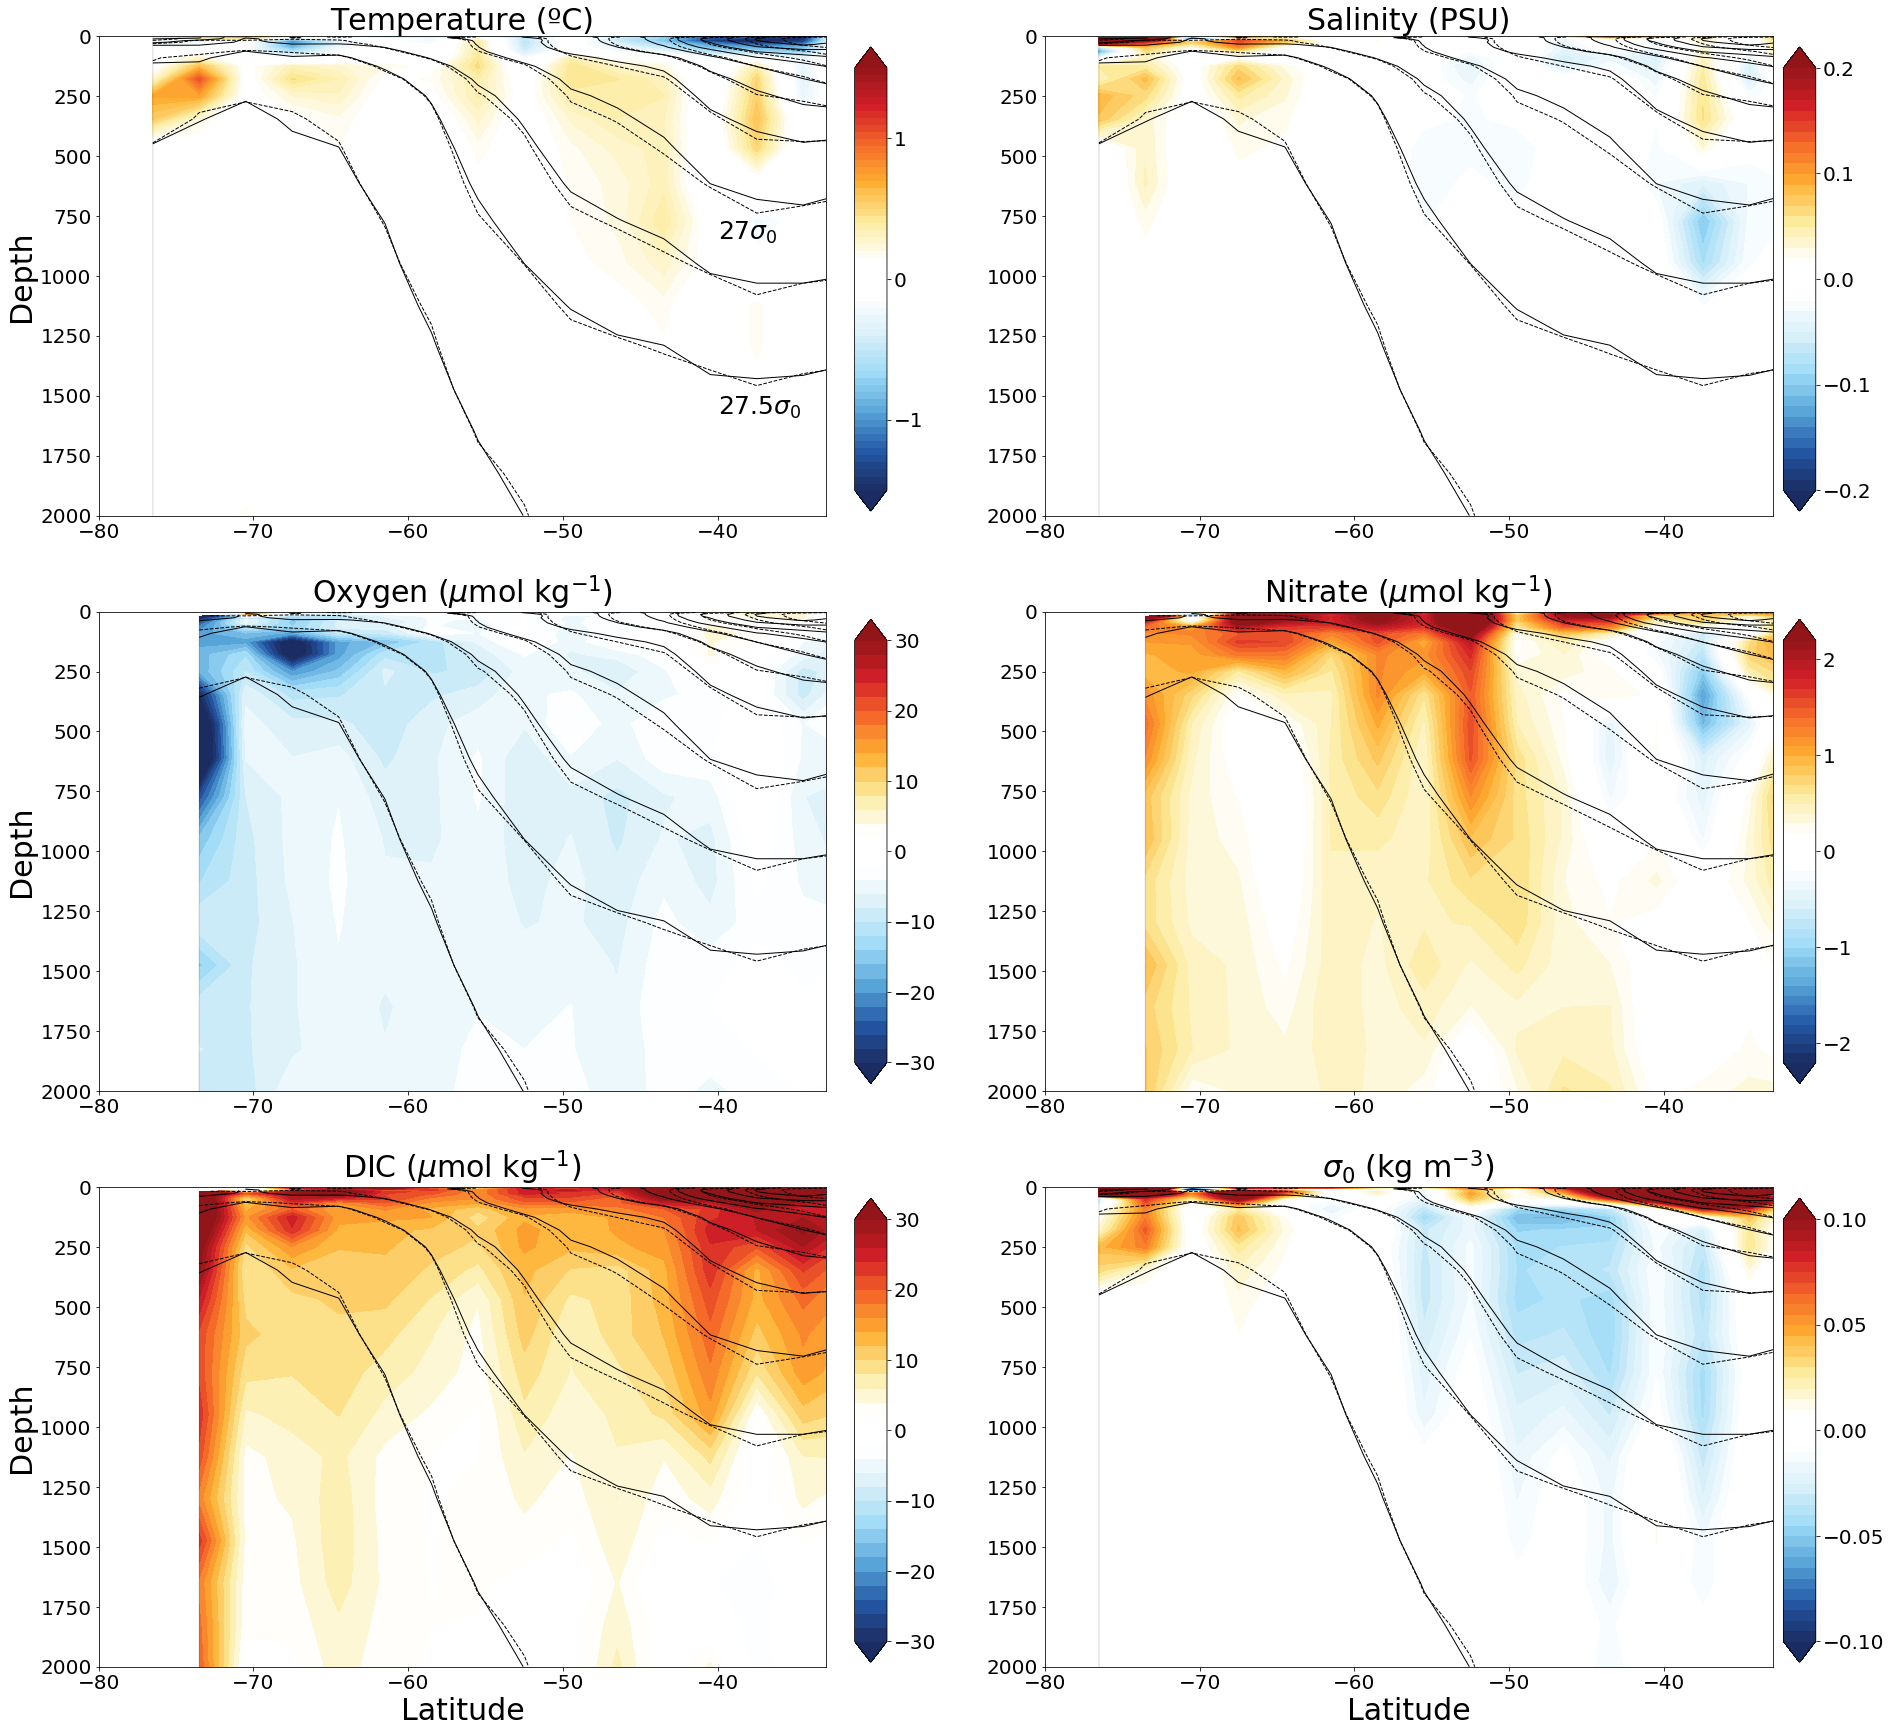

In [26]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_anomaly_Temp_zonal_bathy, Ruth_anomaly_Temp_zonal_bathy.latitude, Ruth_anomaly_Temp_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_anomaly_Salt_zonal_bathy, Ruth_anomaly_Salt_zonal_bathy.latitude, Ruth_anomaly_Salt_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_anomaly_Oxygen_zonal_bathy, Ruth_anomaly_Oxygen_zonal_bathy.latitude, Ruth_anomaly_Oxygen_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_anomaly_Nitrate_zonal_bathy, Ruth_anomaly_Nitrate_zonal_bathy.latitude, Ruth_anomaly_Nitrate_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_anomaly_DIC_zonal_bathy, Ruth_anomaly_DIC_zonal_bathy.latitude, Ruth_anomaly_DIC_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_anomaly_Sigma_zonal_bathy, Ruth_anomaly_Sigma_zonal_bathy.latitude, Ruth_anomaly_Sigma_zonal_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

# figurepath = 'F1_F2-original.png'
# plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

In [27]:
_ , Ruth_SOCCOM_Temp_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_temp_grid_DJFMAM,glodap_temp_grid_bathy)
_ , Ruth_SOCCOM_Salt_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_salt_grid_DJFMAM,glodap_salt_grid_bathy)
_ , Ruth_SOCCOM_Oxygen_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_oxygen_grid_DJFMAM,glodap_oxyg_grid_bathy)
_ , Ruth_SOCCOM_Nitrate_zonal_DJFMAM,_  = zonal_mean_overlapping(soccom_nitrate_grid_DJFMAM,glodap_nitr_grid_bathy)
_ , Ruth_SOCCOM_DIC_zonal_DJFMAM, _ = zonal_mean_overlapping(soccom_dic_grid_DJFMAM,glodap_dic_grid_bathy)
_ , Ruth_SOCCOM_Sigma_zonal_DJFMAM,  _= zonal_mean_overlapping(soccom_sigma_grid_DJFMAM,glodap_sigma_grid_bathy)

In [28]:
Ruth_SOCCOM_Temp_zonal_summer_bias = Ruth_SOCCOM_Temp_zonal_DJFMAM - Ruth_SOCCOM_Temp_zonal
Ruth_SOCCOM_Salt_zonal_summer_bias  = Ruth_SOCCOM_Salt_zonal_DJFMAM - Ruth_SOCCOM_Salt_zonal
Ruth_SOCCOM_Oxygen_zonal_summer_bias  = Ruth_SOCCOM_Oxygen_zonal_DJFMAM - Ruth_SOCCOM_Oxygen_zonal
Ruth_SOCCOM_Nitrate_zonal_summer_bias  = Ruth_SOCCOM_Nitrate_zonal_DJFMAM - Ruth_SOCCOM_Nitrate_zonal
Ruth_SOCCOM_DIC_zonal_summer_bias  = Ruth_SOCCOM_DIC_zonal_DJFMAM - Ruth_SOCCOM_DIC_zonal
Ruth_SOCCOM_Sigma_zonal_summer_bias  = Ruth_SOCCOM_Sigma_zonal_DJFMAM - Ruth_SOCCOM_Sigma_zonal

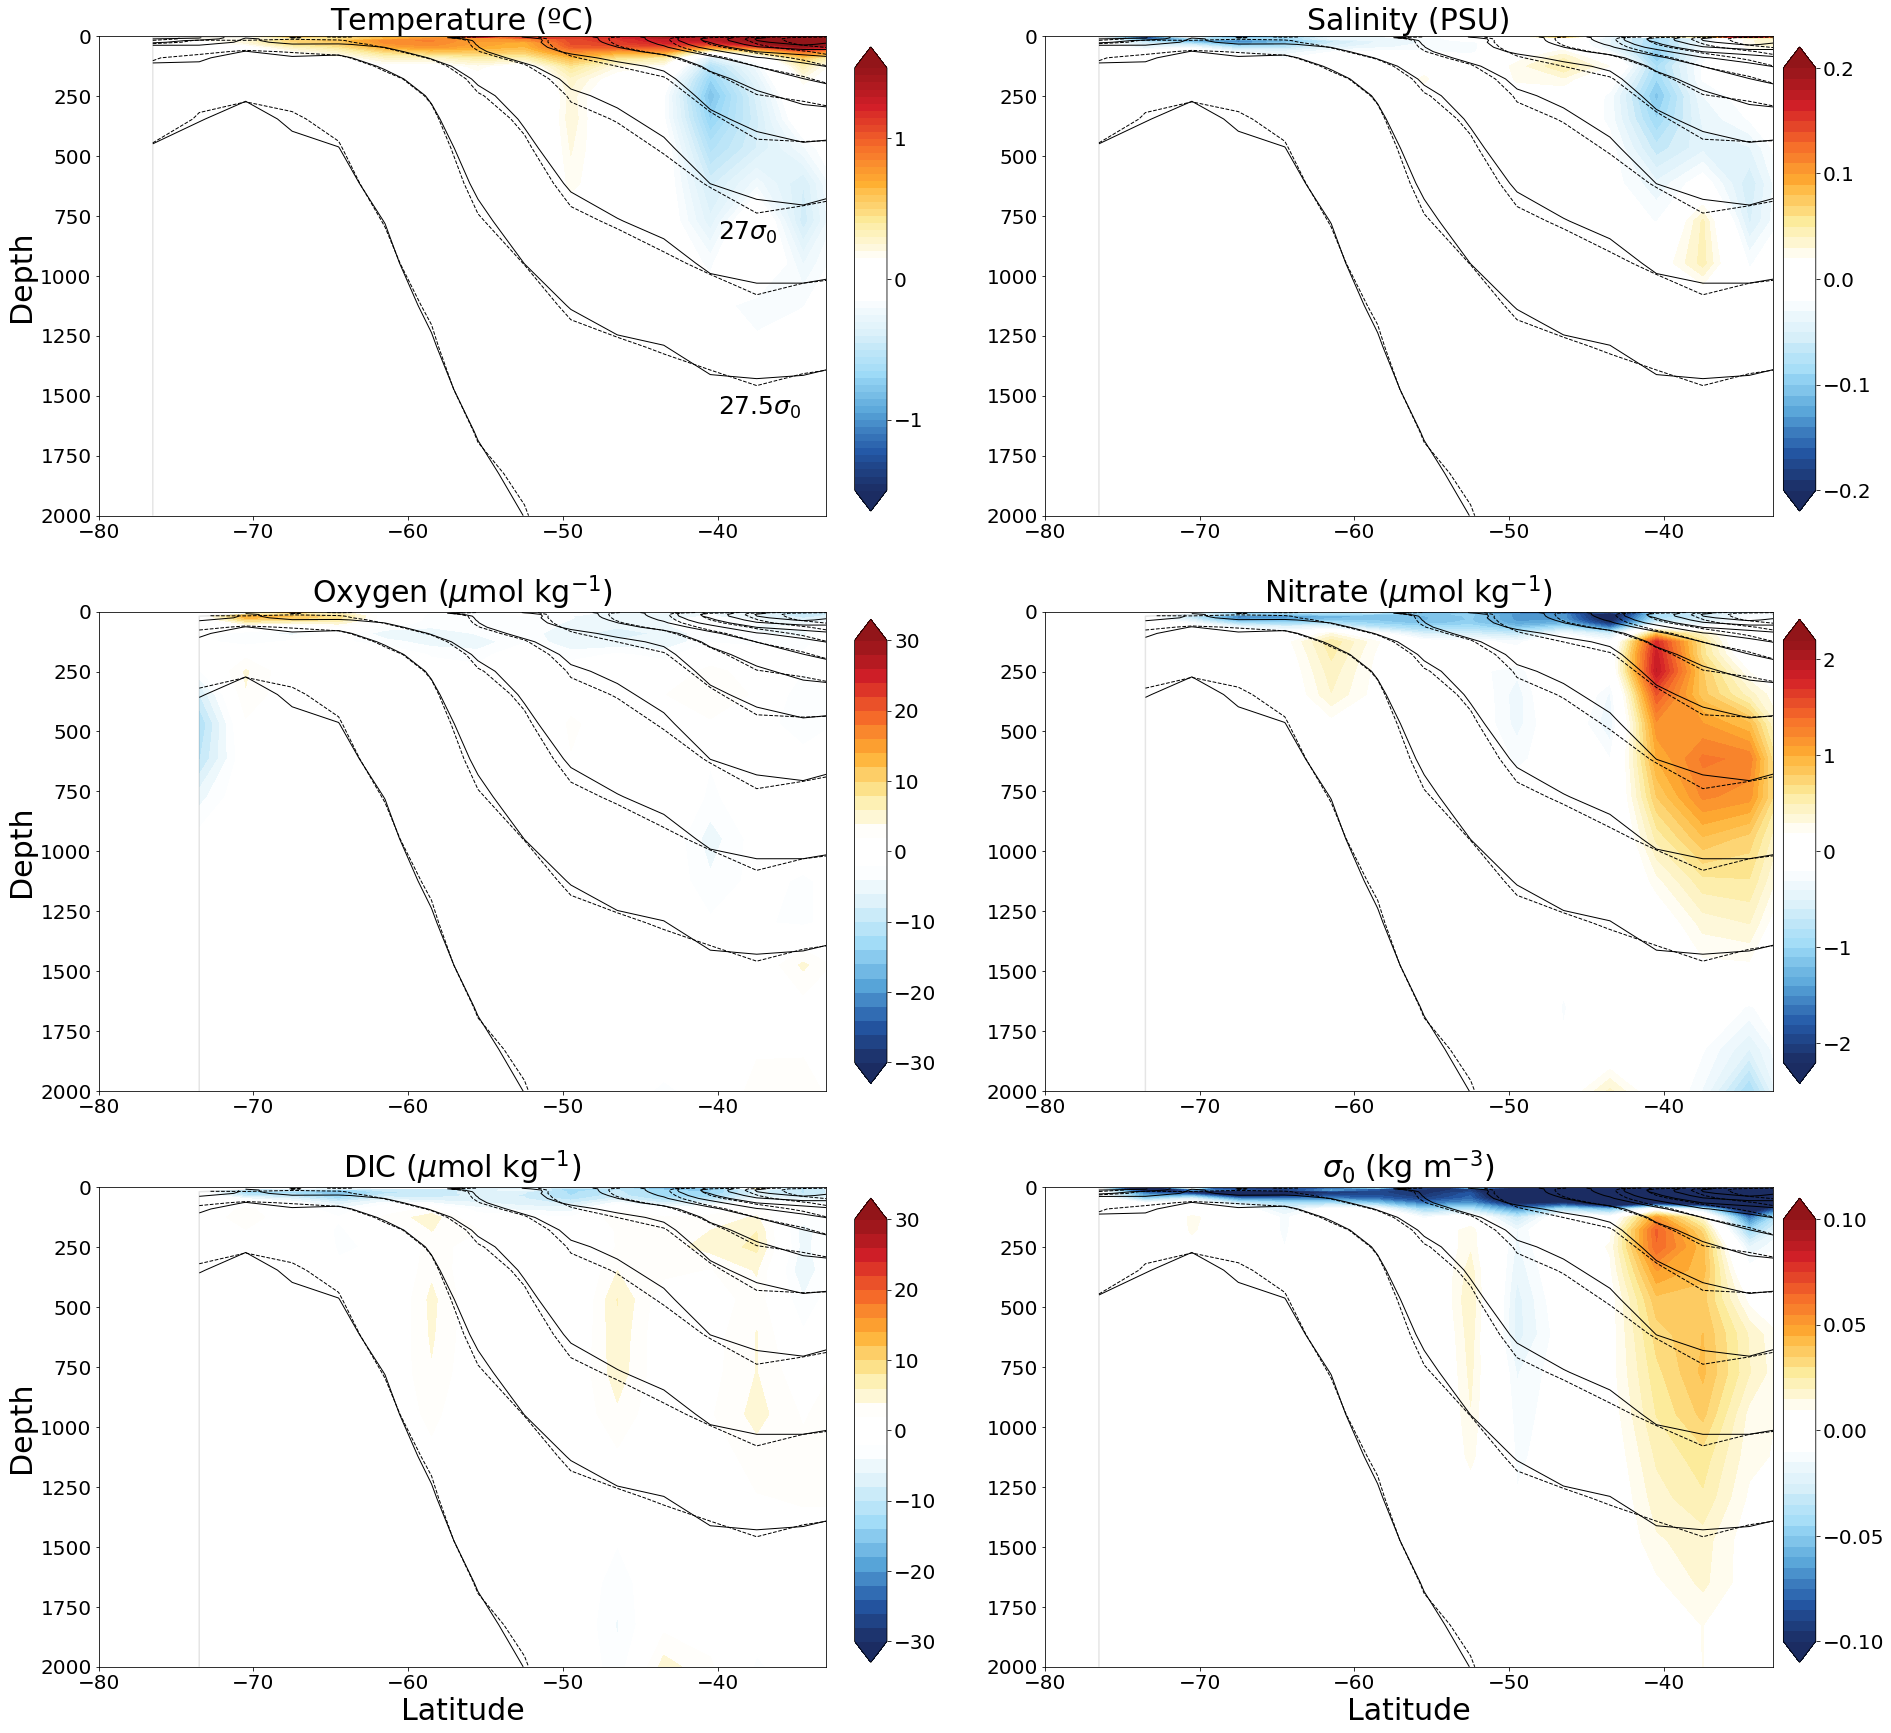

In [29]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_SOCCOM_Temp_zonal_summer_bias, Ruth_SOCCOM_Temp_zonal_summer_bias.latitude, Ruth_SOCCOM_Temp_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_SOCCOM_Salt_zonal_summer_bias, Ruth_SOCCOM_Salt_zonal_summer_bias.latitude, Ruth_SOCCOM_Salt_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_SOCCOM_Oxygen_zonal_summer_bias, Ruth_SOCCOM_Oxygen_zonal_summer_bias.latitude, Ruth_SOCCOM_Oxygen_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_SOCCOM_Nitrate_zonal_summer_bias, Ruth_SOCCOM_Nitrate_zonal_summer_bias.latitude, Ruth_SOCCOM_Nitrate_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_SOCCOM_DIC_zonal_summer_bias, Ruth_SOCCOM_DIC_zonal_summer_bias.latitude, Ruth_SOCCOM_DIC_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_SOCCOM_Sigma_zonal_summer_bias, Ruth_SOCCOM_Sigma_zonal_summer_bias.latitude, Ruth_SOCCOM_Sigma_zonal_summer_bias.depth, cmap , norm , levels,soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_bathy)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

# figurepath = 'F1_F2-reproduction-no-bathymery.png'
# plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

In [30]:
# glodap seasonal bias correction
Ruth_GLODAP_Temp_zonal_BC_bathy = Ruth_GLODAP_Temp_zonal_bathy - Ruth_SOCCOM_Temp_zonal_summer_bias
Ruth_GLODAP_Salt_zonal_BC_bathy = Ruth_GLODAP_Salt_zonal_bathy - Ruth_SOCCOM_Salt_zonal_summer_bias
Ruth_GLODAP_Oxygen_zonal_BC_bathy = Ruth_GLODAP_Oxygen_zonal_bathy - Ruth_SOCCOM_Oxygen_zonal_summer_bias
Ruth_GLODAP_Nitrate_zonal_BC_bathy = Ruth_GLODAP_Nitrate_zonal_bathy - Ruth_SOCCOM_Nitrate_zonal_summer_bias
Ruth_GLODAP_DIC_zonal_BC_bathy = Ruth_GLODAP_DIC_zonal_bathy - Ruth_SOCCOM_DIC_zonal_summer_bias
Ruth_GLODAP_Sigma_zonal_BC_bathy = Ruth_GLODAP_Sigma_zonal_bathy - Ruth_SOCCOM_Sigma_zonal_summer_bias

In [31]:
Ruth_anomaly_Temp_zonal_BC_bathy = Ruth_SOCCOM_Temp_zonal_bathy - Ruth_GLODAP_Temp_zonal_BC_bathy
Ruth_anomaly_Salt_zonal_BC_bathy = Ruth_SOCCOM_Salt_zonal_bathy - Ruth_GLODAP_Salt_zonal_BC_bathy
Ruth_anomaly_Oxygen_zonal_BC_bathy = Ruth_SOCCOM_Oxygen_zonal_bathy - Ruth_GLODAP_Oxygen_zonal_BC_bathy
Ruth_anomaly_Nitrate_zonal_BC_bathy = Ruth_SOCCOM_Nitrate_zonal_bathy - Ruth_GLODAP_Nitrate_zonal_BC_bathy
Ruth_anomaly_DIC_zonal_BC_bathy = Ruth_SOCCOM_DIC_zonal_bathy - Ruth_GLODAP_DIC_zonal_BC_bathy
Ruth_anomaly_Sigma_zonal_BC_bathy = Ruth_SOCCOM_Sigma_zonal_bathy - Ruth_GLODAP_Sigma_zonal_BC_bathy

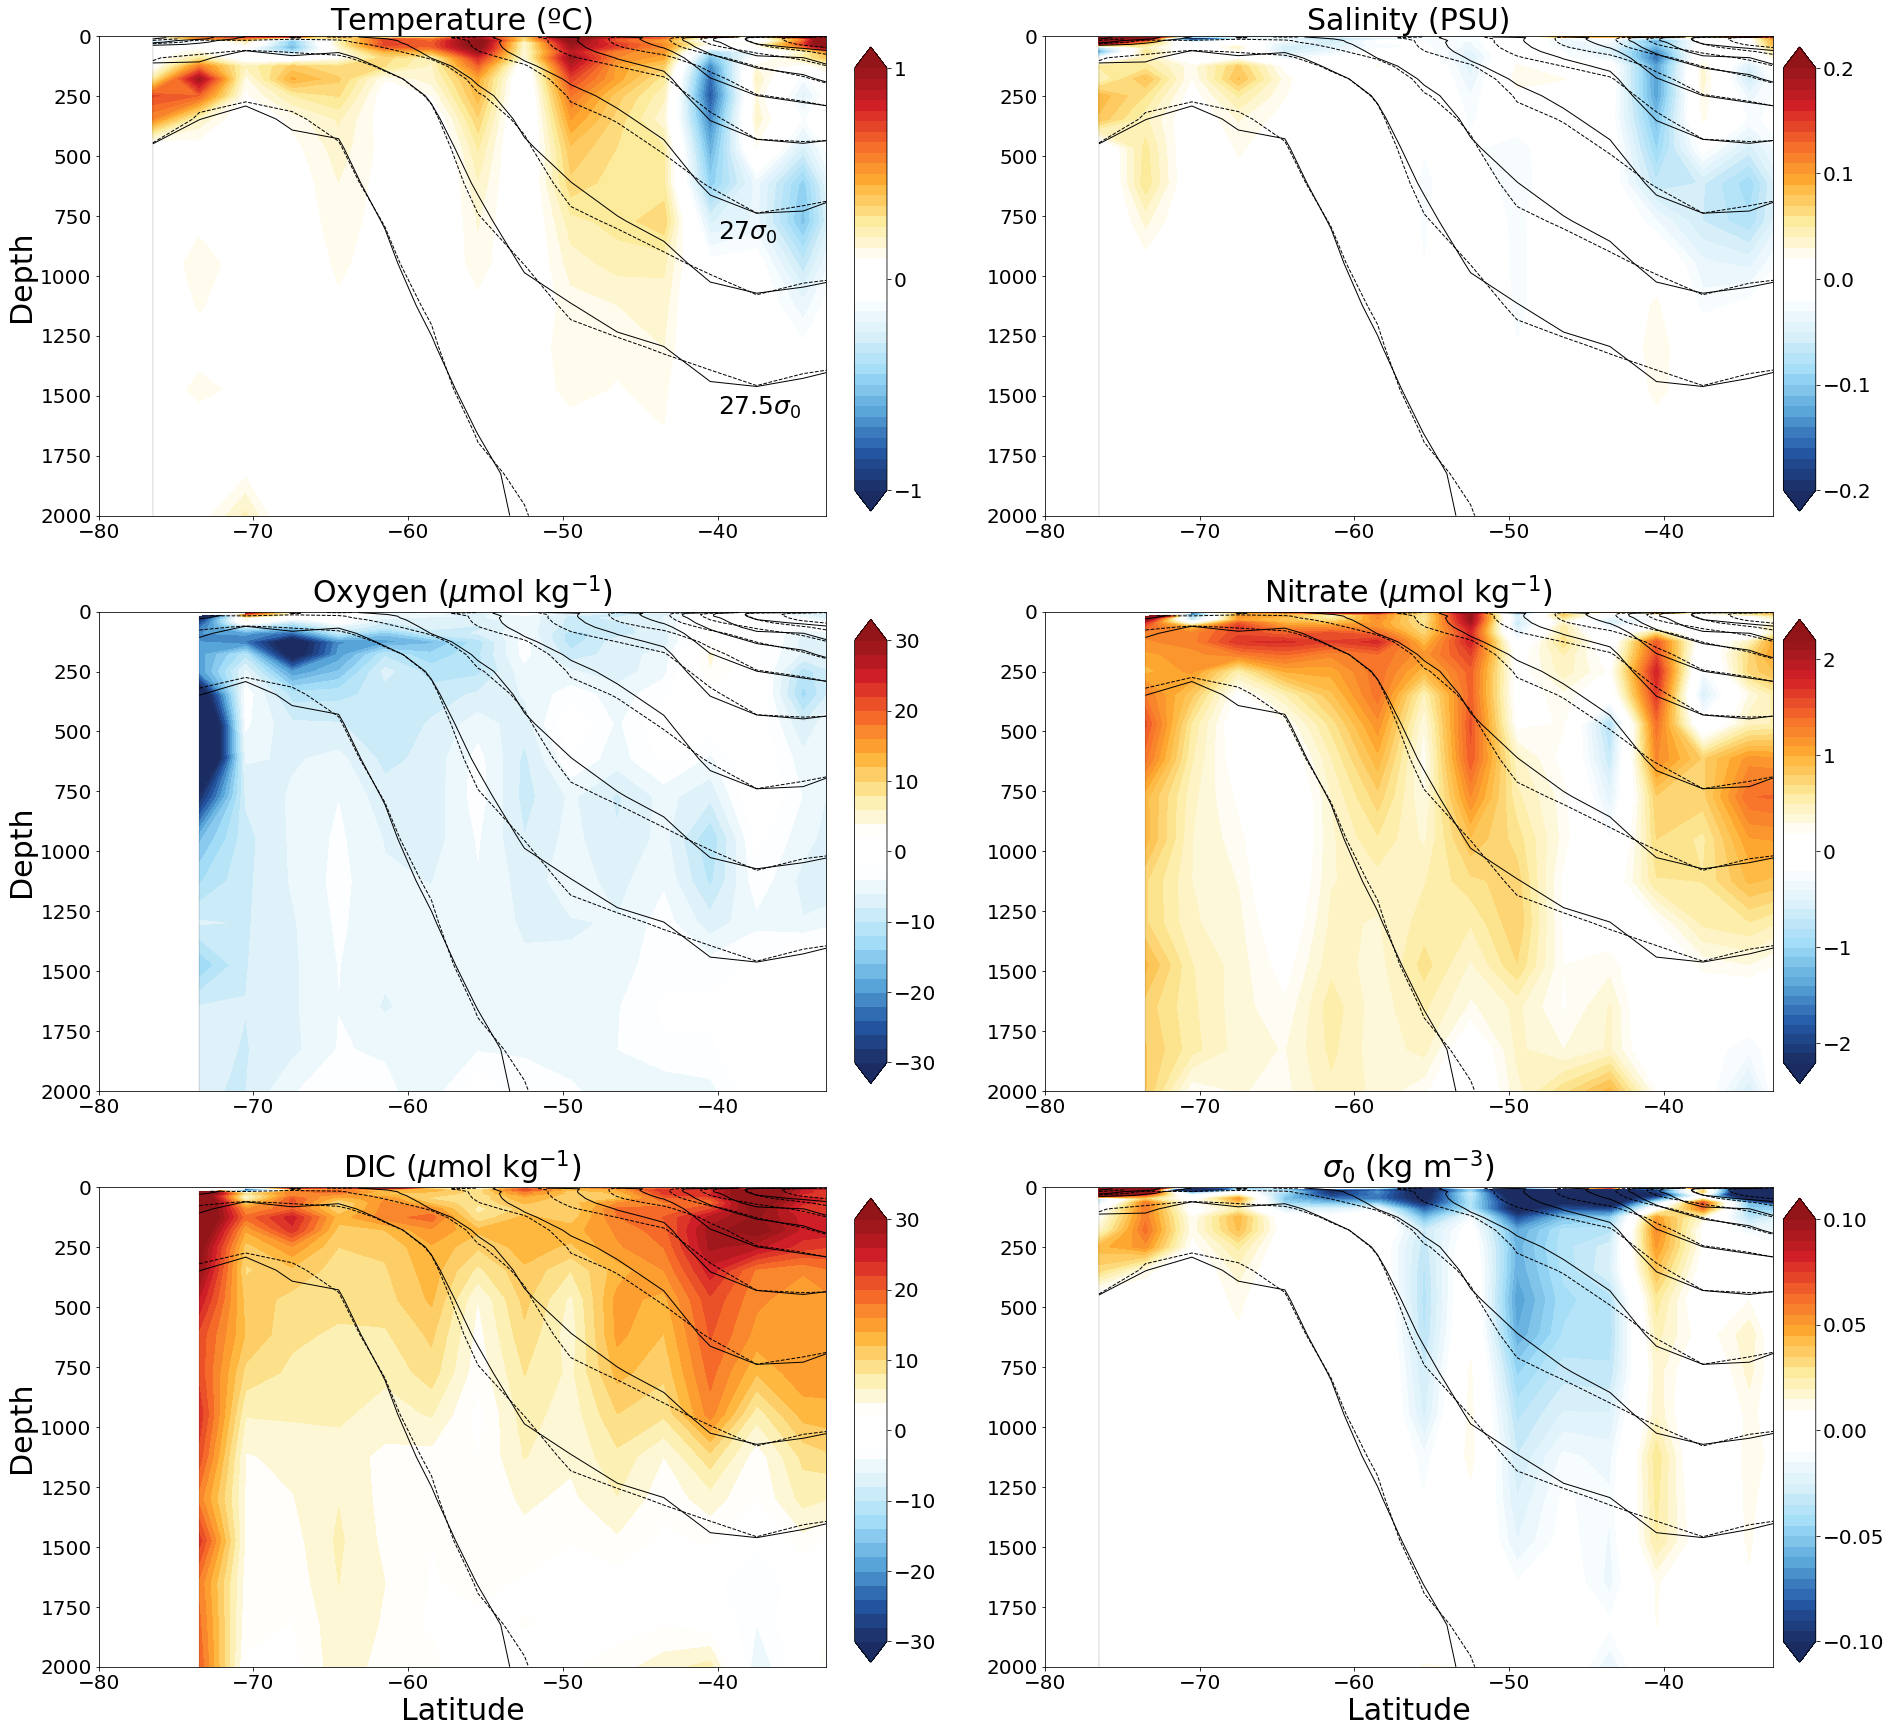

In [32]:
fig = plt.figure(figsize=[30, 30])
gs = gridspec.GridSpec(3,2)
ax, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1])
gs.update(hspace = 0.2, wspace = 0.3)

cmap = nclcmaps.cmap('BlueWhiteOrangeRed')

# temp
norm = col.Normalize(vmin=-1,vmax=1) 
levels = np.arange(-1,1.01,0.05)
temp = zonal_contour_plot_sigma(ax, Ruth_anomaly_Temp_zonal_BC_bathy, Ruth_anomaly_Temp_zonal_BC_bathy.latitude, Ruth_anomaly_Temp_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Temperature (ºC)', fontsize = 30)
ax.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax.text(-40, 850, r'27$\sigma_0$', fontsize = 25)


#salt
norm = col.Normalize(vmin=-0.2,vmax=0.2) 
levels = np.arange(-0.2,0.21,0.01)
salt = zonal_contour_plot_sigma(ax1, Ruth_anomaly_Salt_zonal_BC_bathy, Ruth_anomaly_Salt_zonal_BC_bathy.latitude, Ruth_anomaly_Salt_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax1.set_title('Salinity (PSU)', fontsize = 30)
#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot_sigma(ax2, Ruth_anomaly_Oxygen_zonal_BC_bathy, Ruth_anomaly_Oxygen_zonal_BC_bathy.latitude, Ruth_anomaly_Oxygen_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax2.set_ylabel('Depth', fontsize = 30)
ax2.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot_sigma(ax3, Ruth_anomaly_Nitrate_zonal_BC_bathy, Ruth_anomaly_Nitrate_zonal_BC_bathy.latitude, Ruth_anomaly_Nitrate_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax3.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot_sigma(ax4, Ruth_anomaly_DIC_zonal_BC_bathy, Ruth_anomaly_DIC_zonal_BC_bathy.latitude, Ruth_anomaly_DIC_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax4.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax4.set_ylabel('Depth', fontsize = 30)
ax4.set_xlabel('Latitude', fontsize = 30)
#sigma0
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
sigma = zonal_contour_plot_sigma(ax5, Ruth_anomaly_Sigma_zonal_BC_bathy, Ruth_anomaly_Sigma_zonal_BC_bathy.latitude, Ruth_anomaly_Sigma_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax5.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax5.set_xlabel('Latitude', fontsize = 30)

cax = fig.add_axes([0.475, 0.66, 0.015, 0.215])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.905, 0.66, 0.015, 0.215])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cax = fig.add_axes([0.475, 0.395, 0.015, 0.215])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.395, 0.015, 0.215])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cax = fig.add_axes([0.475, 0.127, 0.015, 0.215])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cax = fig.add_axes([0.905, 0.127, 0.015, 0.215])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])

figurepath = 'F1_F2-reproduction-bathymetry-masked.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)

plt.show()

Now have one big comparison plot to summarise these results (include seasonal bias correction is the original data).

In [35]:
Ben_anomaly_Temp_zonal_BC = Ben_anomaly_Temp_zonal + Ruth_SOCCOM_Temp_zonal_summer_bias
Ben_anomaly_Salt_zonal_BC = Ben_anomaly_Salt_zonal + Ruth_SOCCOM_Salt_zonal_summer_bias
Ben_anomaly_Oxygen_zonal_BC = Ben_anomaly_Oxygen_zonal + Ruth_SOCCOM_Oxygen_zonal_summer_bias
Ben_anomaly_Nitrate_zonal_BC = Ben_anomaly_Nitrate_zonal + Ruth_SOCCOM_Nitrate_zonal_summer_bias
Ben_anomaly_DIC_zonal_BC = Ben_anomaly_DIC_zonal + Ruth_SOCCOM_DIC_zonal_summer_bias

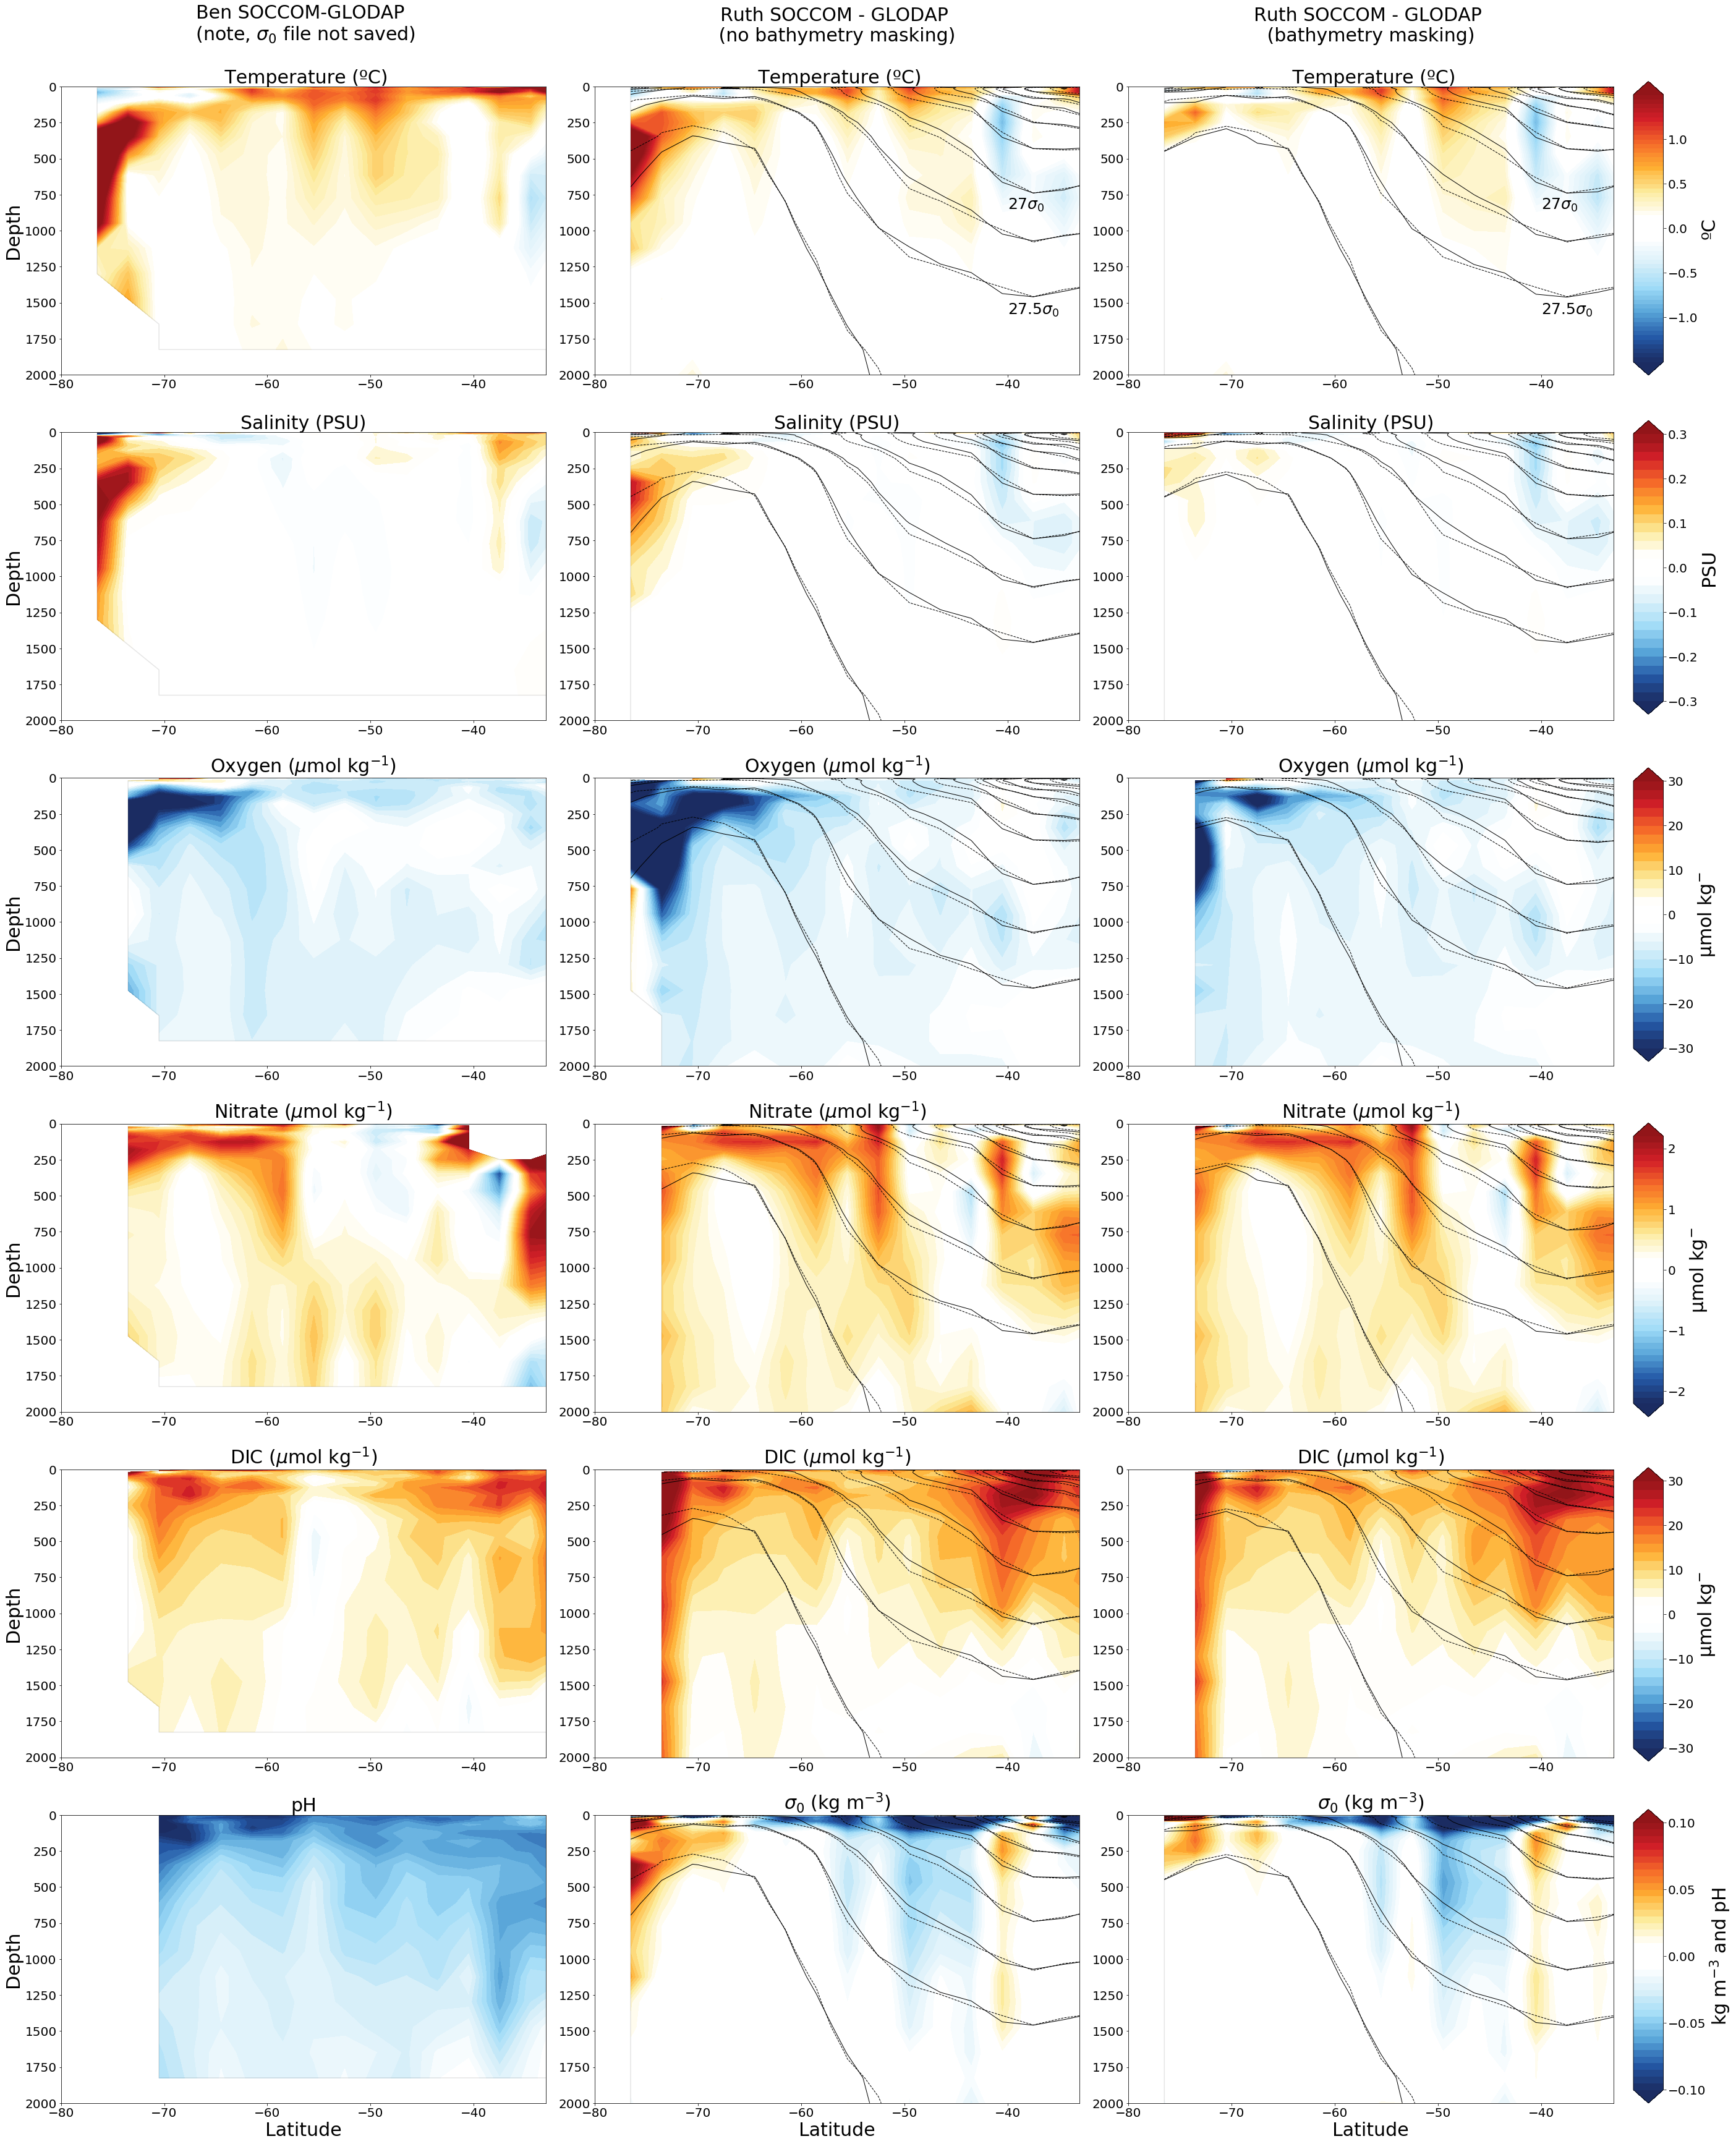

In [62]:
fig = plt.figure(figsize=[45, 60])
gs = gridspec.GridSpec(6,3)
ax, ax1, ax2, ax3, ax4, ax5 , ax6, ax7,ax8= plt.subplot(gs[0,0]), plt.subplot(gs[0,1]),plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2]), plt.subplot(gs[2,0]), plt.subplot(gs[2,1]), plt.subplot(gs[2,2])
ax9, ax10, ax11, ax12, ax13, ax14 , ax15, ax16,ax17= plt.subplot(gs[3,0]), plt.subplot(gs[3,1]),plt.subplot(gs[3,2]), plt.subplot(gs[4,0]), plt.subplot(gs[4,1]), plt.subplot(gs[4,2]), plt.subplot(gs[5,0]), plt.subplot(gs[5,1]), plt.subplot(gs[5,2])
gs.update(hspace = 0.2, wspace = 0.1)


cmap = nclcmaps.cmap('BlueWhiteOrangeRed')
# temp
norm = col.Normalize(vmin=-1.5,vmax=1.5) 
levels = np.arange(-1.5,1.51,0.05)
temp = zonal_contour_plot(ax, Ben_anomaly_Temp_zonal_BC, Ben_anomaly_Temp_zonal_BC.latitude, Ben_anomaly_Temp_zonal_BC.depth, cmap , norm , levels)
ax.set_ylabel('Depth', fontsize = 30)
ax.set_title('Ben SOCCOM-GLODAP \n (note, $\sigma_0$ file not saved) \n \n Temperature (ºC)', fontsize = 30)
temp = zonal_contour_plot_sigma(ax1, Ruth_anomaly_Temp_zonal_BC, Ruth_anomaly_Temp_zonal_BC.latitude, Ruth_anomaly_Temp_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax1.set_title('Ruth SOCCOM - GLODAP \n (no bathymetry masking) \n \n Temperature (ºC)', fontsize = 30)
ax1.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax1.text(-40, 850, r'27$\sigma_0$', fontsize = 25)
temp = zonal_contour_plot_sigma(ax2, Ruth_anomaly_Temp_zonal_BC_bathy, Ruth_anomaly_Temp_zonal_BC_bathy.latitude, Ruth_anomaly_Temp_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax2.set_title('Ruth SOCCOM - GLODAP \n (bathymetry masking) \n \n Temperature (ºC)', fontsize = 30)
ax2.text(-40, 1580, r'27.5$\sigma_0$', fontsize = 25)
ax2.text(-40, 850, r'27$\sigma_0$', fontsize = 25)

#salt
norm = col.Normalize(vmin=-0.3,vmax=0.3) 
levels = np.arange(-0.3,0.31,0.02)
salt = zonal_contour_plot(ax3, Ben_anomaly_Salt_zonal_BC, Ben_anomaly_Salt_zonal_BC.latitude, Ben_anomaly_Salt_zonal_BC.depth, cmap , norm , levels)
ax3.set_ylabel('Depth', fontsize = 30)
ax3.set_title('Salinity (PSU)', fontsize = 30)
salt = zonal_contour_plot_sigma(ax4, Ruth_anomaly_Salt_zonal_BC, Ruth_anomaly_Salt_zonal_BC.latitude, Ruth_anomaly_Salt_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax4.set_title('Salinity (PSU)', fontsize = 30)
salt = zonal_contour_plot_sigma(ax5, Ruth_anomaly_Salt_zonal_BC_bathy, Ruth_anomaly_Salt_zonal_BC_bathy.latitude, Ruth_anomaly_Salt_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax5.set_title('Salinity (PSU)', fontsize = 30)


#oxygen
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
oxygen = zonal_contour_plot(ax6, Ben_anomaly_Oxygen_zonal_BC, Ben_anomaly_Oxygen_zonal_BC.latitude, Ben_anomaly_Oxygen_zonal_BC.depth, cmap , norm , levels)
ax6.set_ylabel('Depth', fontsize = 30)
ax6.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
oxygen = zonal_contour_plot_sigma(ax7, Ruth_anomaly_Oxygen_zonal_BC, Ruth_anomaly_Oxygen_zonal_BC.latitude, Ruth_anomaly_Oxygen_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax7.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)
oxygen = zonal_contour_plot_sigma(ax8, Ruth_anomaly_Oxygen_zonal_BC_bathy, Ruth_anomaly_Oxygen_zonal_BC_bathy.latitude, Ruth_anomaly_Oxygen_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax8.set_title(r'Oxygen ($\mu$mol kg$^{-1}$)', fontsize = 30)

#nitrate
norm = col.Normalize(vmin=-2.2,vmax=2.2) 
levels = np.arange(-2.2,2.201,0.1)
nitrate = zonal_contour_plot(ax9, Ben_anomaly_Nitrate_zonal_BC, Ben_anomaly_Nitrate_zonal_BC.latitude, Ben_anomaly_Nitrate_zonal_BC.depth, cmap , norm , levels)
ax9.set_ylabel('Depth', fontsize = 30)
ax9.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
nitrate = zonal_contour_plot_sigma(ax10, Ruth_anomaly_Nitrate_zonal_BC, Ruth_anomaly_Nitrate_zonal_BC.latitude, Ruth_anomaly_Nitrate_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax10.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)
nitrate = zonal_contour_plot_sigma(ax11, Ruth_anomaly_Nitrate_zonal_BC_bathy, Ruth_anomaly_Nitrate_zonal_BC_bathy.latitude, Ruth_anomaly_Nitrate_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax11.set_title(r'Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 30)

#dic
norm = col.Normalize(vmin=-30,vmax=30) 
levels = np.arange(-30,30.1,2)
dic = zonal_contour_plot(ax12, Ben_anomaly_DIC_zonal_BC, Ben_anomaly_DIC_zonal_BC.latitude, Ben_anomaly_DIC_zonal_BC.depth, cmap , norm , levels)
ax12.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
ax12.set_ylabel('Depth', fontsize = 30)
dic = zonal_contour_plot_sigma(ax13, Ruth_anomaly_DIC_zonal_BC, Ruth_anomaly_DIC_zonal_BC.latitude, Ruth_anomaly_DIC_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax13.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)
dic = zonal_contour_plot_sigma(ax14, Ruth_anomaly_DIC_zonal_BC_bathy, Ruth_anomaly_DIC_zonal_BC_bathy.latitude, Ruth_anomaly_DIC_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax14.set_title(r'DIC ($\mu$mol kg$^{-1}$)', fontsize = 30)

#pH
norm = col.Normalize(vmin=-0.1,vmax=0.1) 
levels = np.arange(-0.1,0.105,0.005)
pH = zonal_contour_plot(ax15, Ben_anomaly_pH_zonal, Ben_anomaly_pH_zonal.latitude, Ben_anomaly_pH_zonal.depth, cmap , norm , levels)
ax15.set_title(r'pH', fontsize = 30)
ax15.set_ylabel('Depth', fontsize = 30)
ax15.set_xlabel('Latitude', fontsize = 30)
sigma = zonal_contour_plot_sigma(ax16, Ruth_anomaly_Sigma_zonal_BC, Ruth_anomaly_Sigma_zonal_BC.latitude, Ruth_anomaly_Sigma_zonal_BC.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC)
ax16.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax16.set_xlabel('Latitude', fontsize = 30)
sigma = zonal_contour_plot_sigma(ax17, Ruth_anomaly_Sigma_zonal_BC_bathy, Ruth_anomaly_Sigma_zonal_BC_bathy.latitude, Ruth_anomaly_Sigma_zonal_BC_bathy.depth, cmap , norm , levels, soccom_sigma = Ruth_SOCCOM_Sigma_zonal_bathy, glodap_sigma = Ruth_GLODAP_Sigma_zonal_BC_bathy)
ax17.set_title(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
ax17.set_xlabel('Latitude', fontsize = 30)


cax = fig.add_axes([0.91, 0.772, 0.015, 0.11])
cbar=plt.colorbar(temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-1,-0.5,0,0.5,1])
cbar.set_label('ºC', fontsize = 30)

cax = fig.add_axes([0.91, 0.645, 0.015, 0.11])
cbar=plt.colorbar(salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
cbar.set_label('PSU', fontsize = 30)

cax = fig.add_axes([0.91, 0.515, 0.015, 0.11])
cbar=plt.colorbar(oxygen,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cbar.set_label('µmol kg$^{-}$', fontsize = 30)

cax = fig.add_axes([0.91, 0.382, 0.015, 0.11])
cbar=plt.colorbar(nitrate,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-2,-1,0,1,2])
cbar.set_label('µmol kg$^{-}$', fontsize = 30)

cax = fig.add_axes([0.91, 0.253, 0.015, 0.11])
cbar=plt.colorbar(dic,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-30,-20,-10,0,10,20,30])
cbar.set_label('µmol kg$^{-}$', fontsize = 30)

cax = fig.add_axes([0.91, 0.125, 0.015, 0.11])
cbar=plt.colorbar(sigma,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-0.1,-0.05,0,0.05,0.1])
cbar.set_label('kg m$^{-3}$ and pH', fontsize = 30)

figurepath = 'F1_F2-reproduction.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,frameon=None)


plt.show()